# Mean SST per region
# PDF of different models for DV8

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from dask import delayed
import imageio
#from joblib import Parallel, delayed
import matplotlib.dates as mdates
import intake
from DV8_functions_1 import *
#DV8_functions(1) packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
#my functions:


import matplotlib.colors as mcolors

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import dask
from dask.distributed import Client, LocalCluster
import bokeh
import subprocess
import re

import warnings
#warnings.filterwarnings('ignore')


In [2]:


dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32,threads_per_worker=1)
client = Client(cluster)
client

/home/b/b382616/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33107 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:40977' processes=32 threads=32, memory=250.00 GiB>

# LOAD DATA
## Only take latitudes up to 70°N, to retain only ice-free oceans
## Convert ICON and IFS-FESOM longitudes from 0->360 to -180->180

In [3]:

def lon_180w_180e(ds_sice: xr.DataArray):
    ds_sice = (
        ds_sice
        .assign_coords(lon=lambda x: (x.lon - 180) % 360 - 180)
        .sortby('lon'))

    return ds_sice

In [4]:
# OSTIA ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ds = ds.sel(lat=slice(None, 70))
ossta=ds['dat_anomaly']

# OSTIA BLOBS
#file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_track_1982_2014_maxanom5_mask70_oct25.zarr'
#oblobs = xr.open_zarr(str(file_name), chunks={})


In [5]:
# ICON HIST ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 10, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
i_ds = xr.open_zarr(str(file_name), chunks=chunks)
i_ds=lon_180w_180e(i_ds)
i_ds = i_ds.sel(lat=slice(None, 70))
i_ds = i_ds.interp(lat=ossta.lat, lon=ossta.lon)
issta=i_ds['dat_anomaly']



# ICON HIST BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_track_1982_2014_maxanom5_mask70_oct25.zarr'
iblobs = xr.open_zarr(str(file_name), chunks={})
iblobs=lon_180w_180e(iblobs)

/tmp/ipykernel_890713/1116081157.py:4: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  i_ds = xr.open_zarr(str(file_name), chunks=chunks)


In [6]:
# IFS-FESOM ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOMhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 10, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
f_ds = xr.open_zarr(str(file_name), chunks=chunks)
f_ds=lon_180w_180e(f_ds)
f_ds = f_ds.sel(lat=slice(None, 70))
f_ds = f_ds.interp(lat=ossta.lat, lon=ossta.lon)
fssta=f_ds['dat_anomaly']



# IFS-FESOM BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOM_track_1982_2014_maxanom5_mask70_oct25.zarr'
fblobs = xr.open_zarr(str(file_name), chunks={})
fblobs=lon_180w_180e(fblobs)

/tmp/ipykernel_890713/1377698379.py:4: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  f_ds = xr.open_zarr(str(file_name), chunks=chunks)


#SST

# OSTIA
time_chunksize = 1000
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

dat = cat['dkrz.disk.observations.OSTIA.OSTIA.daily']#-output'][model][expid][version]['ocean'][gridspec]
sst = dat.to_dask()
sst=sst['sst'].astype(np.float32).coarsen(lat=5, lon=5,boundary='pad').mean()
sst=sst.chunk(chunks={'time':30, 'lat':-1, 'lon':-1})
sst=sst.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))
sst=sst-273.15

# ICON HISTORICAL
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_ic = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').chunk({'time':30, 'lat':-1, 'lon':-1})
sst_ic=sst_ic.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))

# IFS FESOM
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.ifs-fesom2-sr.hist-1950.v20240304.ocean.gr025']#.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_f = dat['2D_daily_avg_1950-2014'].to_dask().avg_tos.isel(depth=0).drop_vars('depth').chunk({'time':30, 'lat':'auto', 'lon':'auto'})
sst_f=sst_f.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))
            


# Examples

# Regional masks
### Create regional masks based on SST variance relevance. You have to download the oceanic regions from the shapefile at
Flanders Marine Institute (2021). Global Oceans and Seas, version 1. Available online at https://www.marineregions.org/. https://doi.org/10.14284/542.
## and put it in the same place as your shapefile_path. This file is then heavily modified to  adapt it to the wanted regions.

In [ ]:
##You have to provide an example_sst for the coeanic regions masks to be created: Any single time slice of lat and lon will work.
##Save it to wherever the function create_shapefile_oceanic_regions_mask points to


##for OSTIA
#file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
#chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
#ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


#ds_exmp['dat_anomaly'].isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_ostia.nc')

##for ICON
#issta.isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_icon.nc')

##for IFS FESOM

#fssta.isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_ifsfesom.nc')

Loading existing masks...
Loading existing masks...
Using renamed shapefile-based region colors


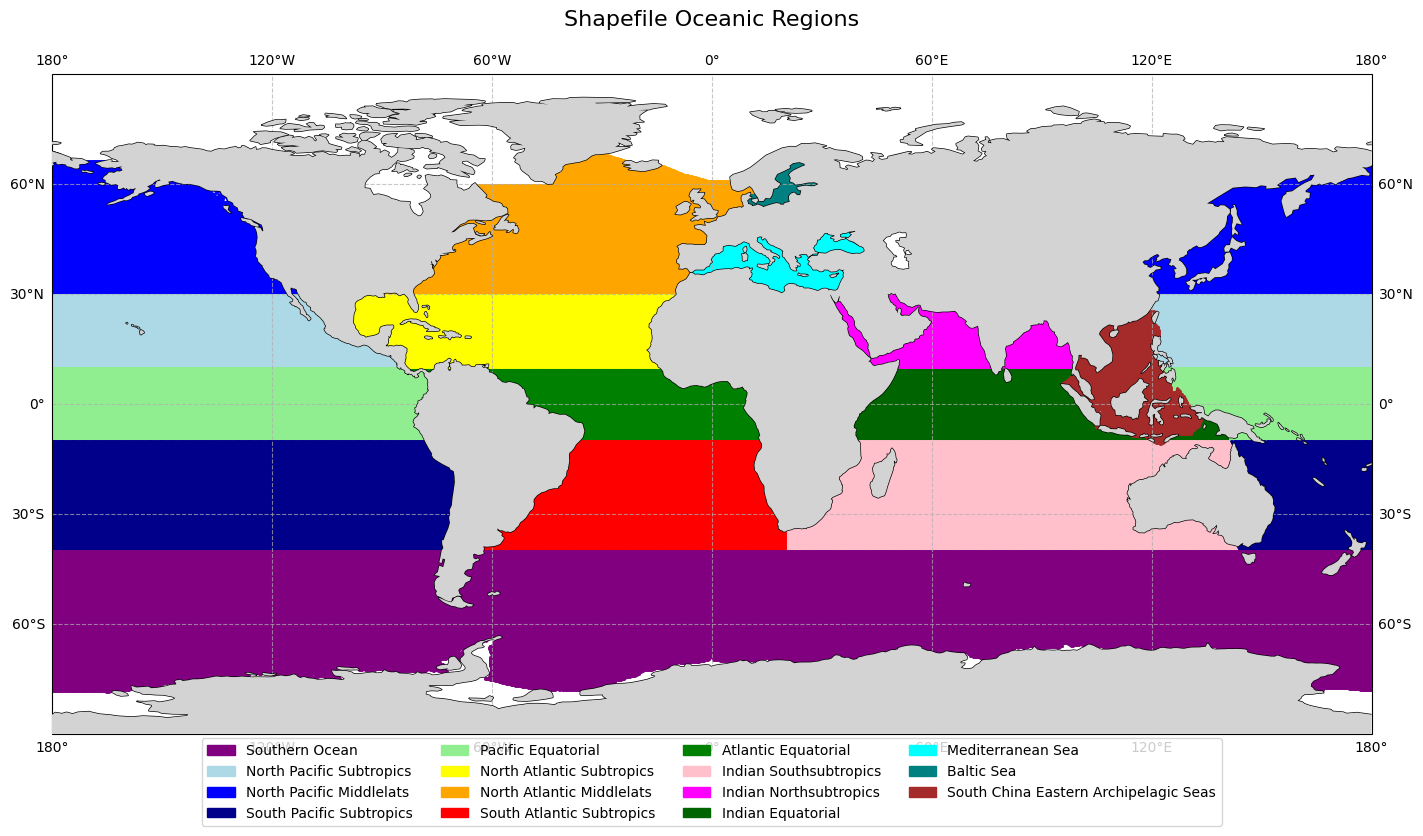

In [7]:

# LATS and LONS for mask
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


lats=ds_exmp.lat
lons=ds_exmp.lon

# Old method (coordinate-based)
#masks_old = create_oceanic_regions_mask(lats, lons, method='coordinate')

# Create shapefile masks (no example_sst needed!)
masks = create_oceanic_regions_mask(lats, lons, method='shapefile')

# Or plot directly
fig, ax = plot_shapefile_regions(lats, lons)

# REGIONAL PDFs of SST anomaly

In [7]:
# to select only one model:
models_dict = {
    'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),
}

In [ ]:
# This will give you the same PDF plots with threshold lines, but for each region
regional_thresholds, regional_pdfs, masks_dict = analyze_regional_extreme_thresholds(
    models_dict, 
    regions=None,  # All regions
    percentiles=[90, 95, 99],
    xlim=(-1, 1),
    plot_percentile_lines=False
)

REGIONAL EXTREME DETECTION THRESHOLD ANALYSIS
Using xlim: [-1, 1]
Plot percentile lines: False
Creating model-specific masks...
Creating masks for OSTIA...
Loading existing masks...
  OSTIA grid: (640,) x (1440,)
Creating masks for ICON...
Loading existing masks...
  ICON grid: (640,) x (1440,)
Creating masks for IFS-FESOM...
Loading existing masks...
  IFS-FESOM grid: (640,) x (1440,)
Computing regional thresholds and PDFs...

Processing Atlantic_Equatorial...
  OSTIA...
  ICON...
  IFS-FESOM...


In [ ]:

# If that works, you can try more regions
pdfs_full, extremes_full, masks_dict_full = quick_regional_analysis(
    models_dict,
    regions=None,
    xlim=(-2,2)
)

In [ ]:
analyze_regional_extreme_thresholds_memory_efficient deleted
analyze_regional_extreme_thresholds becomes regional_thresholds

MEMORY-EFFICIENT REGIONAL EXTREME THRESHOLD ANALYSIS
Using fewer percentiles and efficient computation

Processing equatorial...
  OSTIA...
    136,211 points
  ICON...
    136,643 points

Processing southern_ocean...
  OSTIA...
    180,841 points
  ICON...
    181,061 points

Processing eastern_boundary...
  OSTIA...
    61,736 points
  ICON...
    61,579 points

Processing western_boundary...
  OSTIA...
    59,575 points
  ICON...
    59,119 points

Processing north_atlantic...
  OSTIA...
    16,041 points
  ICON...
    15,772 points

CREATING VISUALIZATIONS...


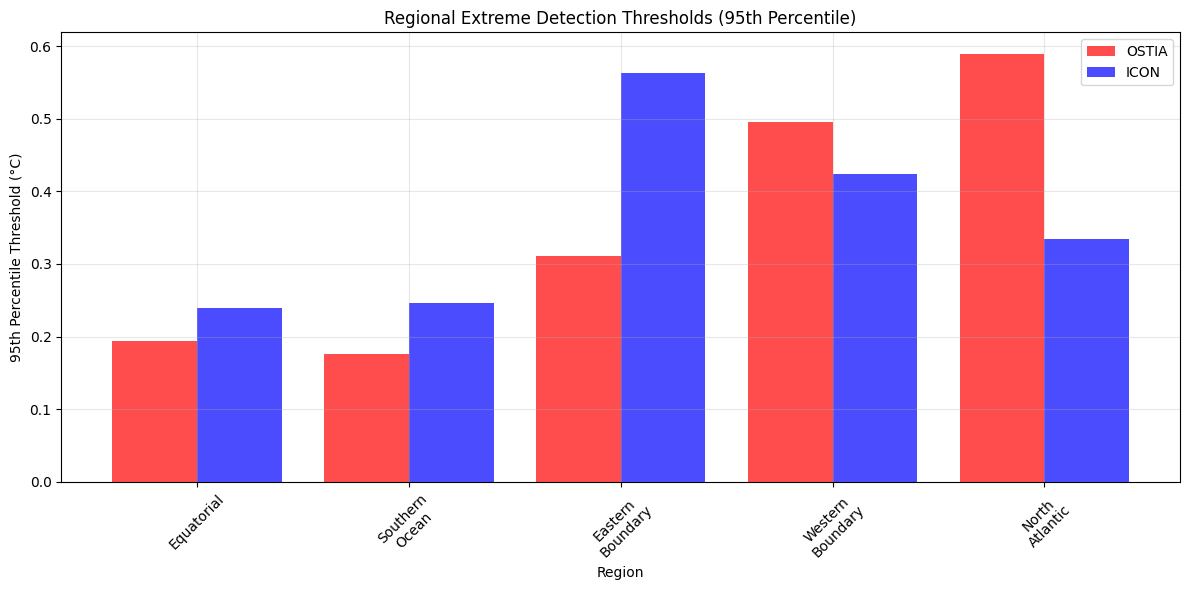


REGIONAL THRESHOLDS (°C):
Region               |      OSTIA |       ICON
----------------------------------------------
Equatorial           |      0.194 |      0.239 | 
Southern Ocean       |      0.176 |      0.246 | 
Eastern Boundary     |      0.311 |      0.563 | 
Western Boundary     |      0.496 |      0.424 | 
North Atlantic       |      0.589 |      0.334 | 


In [10]:
# For more percentiles and detailed analysis
extremes_detailed = analyze_regional_extreme_thresholds_memory_efficient(
    models_dict, 
    masks_dict, 
    regions=None,
    percentiles=[90, 95, 99, 99.5, 99.9]  # More percentiles
)

MEMORY-EFFICIENT REGIONAL EXTREME THRESHOLD ANALYSIS
Using fewer percentiles and efficient computation

Processing equatorial...
  OSTIA...
    136,211 points
  ICON...
    136,643 points

Processing southern_ocean...
  OSTIA...
    180,841 points
  ICON...
    181,061 points

Processing eastern_boundary...
  OSTIA...
    61,736 points
  ICON...
    61,579 points

Processing western_boundary...
  OSTIA...
    59,575 points
  ICON...
    59,119 points

Processing north_atlantic...
  OSTIA...
    16,041 points
  ICON...
    15,772 points

CREATING VISUALIZATIONS...


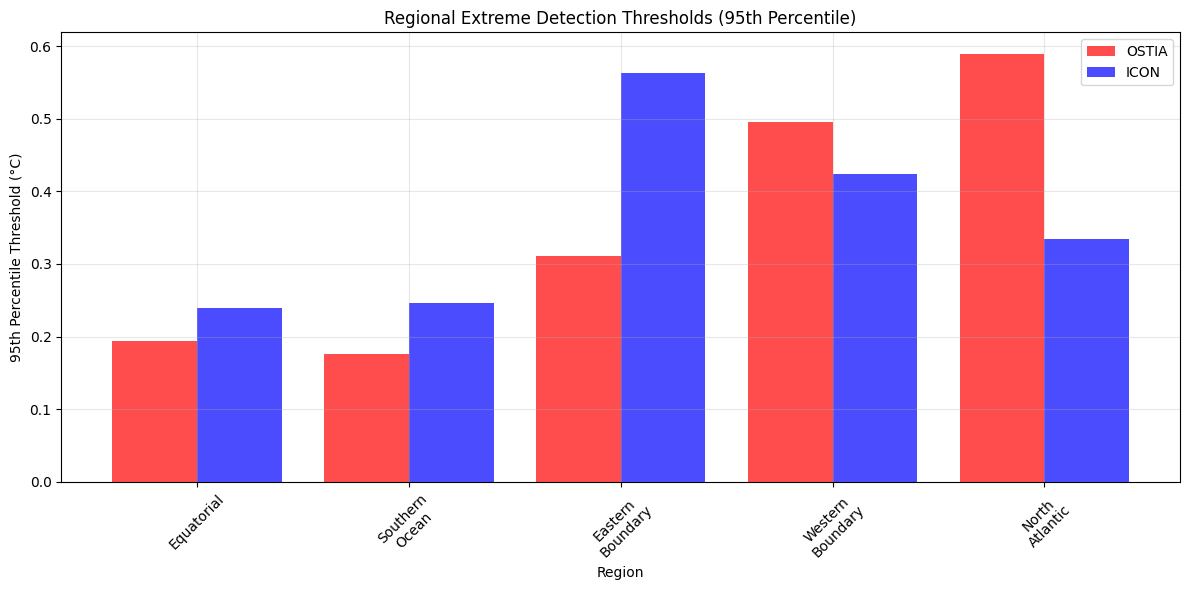


REGIONAL THRESHOLDS (°C):
Region               |      OSTIA |       ICON
----------------------------------------------
Equatorial           |      0.194 |      0.239 | 
Southern Ocean       |      0.176 |      0.246 | 
Eastern Boundary     |      0.311 |      0.563 | 
Western Boundary     |      0.496 |      0.424 | 
North Atlantic       |      0.589 |      0.334 | 


{'thresholds': {'equatorial': {'OSTIA': {90: np.float32(0.16678515),
    95: np.float32(0.19370164),
    99: np.float32(0.2506804),
    99.5: np.float32(0.259994),
    99.9: np.float32(0.2808701)},
   'ICON': {90: np.float32(0.2176951),
    95: np.float32(0.23892829),
    99: np.float32(0.26695246),
    99.5: np.float32(0.27302766),
    99.9: np.float32(0.28347558)}},
  'southern_ocean': {'OSTIA': {90: np.float32(0.12930454),
    95: np.float32(0.17613749),
    99: np.float32(0.26357338),
    99.5: np.float32(0.29217097),
    99.9: np.float32(0.33605993)},
   'ICON': {90: np.float32(0.19487906),
    95: np.float32(0.24602455),
    99: np.float32(0.3360582),
    99.5: np.float32(0.36529365),
    99.9: np.float32(0.43024784)}},
  'eastern_boundary': {'OSTIA': {90: np.float32(0.25017428),
    95: np.float32(0.3113699),
    99: np.float32(0.40176982),
    99.5: np.float32(0.41786113),
    99.9: np.float32(0.4375602)},
   'ICON': {90: np.float32(0.4428006),
    95: np.float32(0.5634231),
  

In [9]:
analyze_regional_extreme_thresholds_memory_efficient(models_dict, masks_dict, regions=None, percentiles=[90, 95, 99,99.5,99.9])

# regional seasonal PDF

In [7]:
def create_hemispheric_regions_mask(lats, lons):
    """
    Create hemispheric versions of oceanic regions masks
    Returns masks for both northern and southern hemispheres for each region
    """
    # First create the standard regions
    base_masks = create_oceanic_regions_mask(lats, lons)
    
    # Create hemisphere masks
    if lats.ndim == 1:
        lon_grid, lat_grid = np.meshgrid(lons, lats)
    else:
        lat_grid, lon_grid = lats, lons
    
    northern_hemisphere = lat_grid >= 0
    southern_hemisphere = lat_grid < 0
    
    hemispheric_masks = {}
    
    for region_name, base_mask in base_masks.items():
        # Northern hemisphere version
        hemispheric_masks[f'{region_name}_north'] = base_mask & northern_hemisphere
        # Southern hemisphere version  
        hemispheric_masks[f'{region_name}_south'] = base_mask & southern_hemisphere
    
    return hemispheric_masks


def analyze_seasonal_regional_pdfs_efficient(models_dict, regions=None, seasons=['DJF', 'MAM', 'JJA', 'SON'], 
                                            xlim=(-2, 2), plot_percentile_lines=False, percentiles=[90, 95, 99]):
    """
    Efficient seasonal regional PDF analysis by first splitting regions by hemisphere
    """
    print("EFFICIENT SEASONAL REGIONAL PDF ANALYSIS")
    print("=" * 45)
    print(f"Seasons: {seasons}")
    print(f"X-axis limits: {xlim}")
    
    # Create hemispheric masks for each model
    hemispheric_masks_dict = {}
    for model_name, (ds, var_name) in models_dict.items():
        print(f"Creating hemispheric masks for {model_name}...")
        lats = ds.lat.values
        lons = ds.lon.values
        hemispheric_masks_dict[model_name] = create_hemispheric_regions_mask(lats, lons)
    
    if regions is None:
        # Use base regions (will be split into north/south automatically)
        sample_masks = hemispheric_masks_dict[list(hemispheric_masks_dict.keys())[0]]
        base_regions = set([name.replace('_north', '').replace('_south', '') for name in sample_masks.keys()])
        regions = list(base_regions)
    
    # Define season to month mapping
    season_months = {
        'DJF': [12, 1, 2],   # December, January, February
        'MAM': [3, 4, 5],    # March, April, May
        'JJA': [6, 7, 8],    # June, July, August
        'SON': [9, 10, 11]   # September, October, November
    }
    
    # Define colors
    model_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    season_colors = {'DJF': 'darkblue', 'MAM': 'green', 'JJA': 'red', 'SON': 'orange'}
    
    # Initialize results
    seasonal_pdfs = {}
    seasonal_thresholds = {}
    
    # Process one region at a time to save memory
    for region_name in regions:
        print(f"\nProcessing {region_name}...")
        seasonal_pdfs[region_name] = {}
        seasonal_thresholds[region_name] = {}
        
        # Get hemispheric versions for this region
        hemispheric_regions = {
            'north': f'{region_name}_north',
            'south': f'{region_name}_south'
        }
        
        # Process each season
        for season in seasons:
            print(f"  Season: {season}")
            seasonal_pdfs[region_name][season] = {}
            seasonal_thresholds[region_name][season] = {}
            
            target_months = season_months[season]
            
            # Process each model
            for model_idx, (model_name, (ds, var_name)) in enumerate(models_dict.items()):
                print(f"    Model: {model_name}")
                
                # Get time information
                times = ds.time
                if hasattr(times, 'dt'):
                    months = times.dt.month.values
                else:
                    # Fallback for different time formats
                    try:
                        months = times.dt.month.values
                    except:
                        print(f"      Warning: Could not extract months from time dimension")
                        continue
                
                # Create time mask for this season
                time_mask = np.isin(months, target_months)
                
                # Combine data from both hemispheres
                all_seasonal_data = []
                
                for hemisphere, hem_region_name in hemispheric_regions.items():
                    if hem_region_name not in hemispheric_masks_dict[model_name]:
                        continue
                    
                    # Get hemispheric mask
                    hem_mask = hemispheric_masks_dict[model_name][hem_region_name]
                    
                    # Apply mask and time selection
                    try:
                        # For 3D data, we need to be careful with memory
                        if ds[var_name].ndim == 3:
                            # Select only the time steps we need first (big memory saving!)
                            seasonal_data = ds[var_name].isel(time=time_mask)
                            # Then apply spatial mask
                            hem_seasonal_data = seasonal_data.where(hem_mask)
                        else:
                            # 2D data (already time-averaged)
                            hem_seasonal_data = ds[var_name].where(hem_mask)
                        
                        # Flatten and collect data
                        values = hem_seasonal_data.values.flatten()
                        clean_values = values[~np.isnan(values)]
                        all_seasonal_data.extend(clean_values)
                        
                        print(f"      {hemisphere}: {len(clean_values):,} points")
                        
                    except Exception as e:
                        print(f"      Error processing {hemisphere} hemisphere: {e}")
                        continue
                
                if len(all_seasonal_data) == 0:
                    print(f"      No data for {region_name} {season}")
                    continue
                
                # Convert to numpy array for processing
                all_seasonal_data = np.array(all_seasonal_data)
                print(f"      Total: {len(all_seasonal_data):,} points")
                
                # Compute percentiles
                thresholds = {}
                for p in percentiles:
                    thresholds[p] = np.percentile(all_seasonal_data, p)
                seasonal_thresholds[region_name][season][model_name] = thresholds
                
                # Compute KDE with sampling for large datasets
                sample_size = min(5000, len(all_seasonal_data))
                if len(all_seasonal_data) > sample_size:
                    step = len(all_seasonal_data) // sample_size
                    sample_data = all_seasonal_data[::step]
                else:
                    sample_data = all_seasonal_data
                
                try:
                    kde = gaussian_kde(sample_data)
                    x_points = np.linspace(xlim[0], xlim[1], 200)  # Reduced points for speed
                    pdf_values = kde(x_points)
                    
                    seasonal_pdfs[region_name][season][model_name] = {
                        'x_points': x_points,
                        'pdf_values': pdf_values,
                        'color': model_colors[model_idx % len(model_colors)],
                        'stats': {
                            'mean': np.mean(all_seasonal_data),
                            'std': np.std(all_seasonal_data),
                            'n_points': len(all_seasonal_data),
                            'sample_size': len(sample_data)
                        }
                    }
                    
                    print(f"      Mean: {np.mean(all_seasonal_data):.3f}, Std: {np.std(all_seasonal_data):.3f}")
                    
                except Exception as e:
                    print(f"      Error computing KDE: {e}")
                    continue
        
        # Clear memory after processing each region
        import gc
        gc.collect()
    
    # Create visualizations
    print(f"\nCreating visualizations...")
    
    # FIGURE 1: One plot per region, seasons as subplots
    for region_name in regions:
        if not seasonal_pdfs[region_name]:
            continue
            
        print(f"Plotting {region_name}...")
        
        n_seasons = len(seasons)
        n_cols = min(2, n_seasons)
        n_rows = (n_seasons + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
        if n_seasons == 1:
            axes = np.array([axes])
        axes = axes.ravel()
        
        for season_idx, season in enumerate(seasons):
            if season_idx >= len(axes):
                break
                
            ax = axes[season_idx]
            
            if season not in seasonal_pdfs[region_name]:
                continue
                
            # Plot PDFs for each model in this season
            for model_name, pdf_data in seasonal_pdfs[region_name][season].items():
                ax.plot(pdf_data['x_points'], pdf_data['pdf_values'],
                       color=pdf_data['color'], label=model_name, linewidth=2, alpha=0.8)
                
                # Add percentile lines if enabled
                if (plot_percentile_lines and 
                    season in seasonal_thresholds[region_name] and 
                    model_name in seasonal_thresholds[region_name][season]):
                    
                    thresholds = seasonal_thresholds[region_name][season][model_name]
                    for j, (p, threshold) in enumerate(thresholds.items()):
                        if j < len(percentile_colors) and xlim[0] <= threshold <= xlim[1]:
                            ax.axvline(threshold, color='gray', linestyle='--', alpha=0.5)
            
            ax.set_xlabel('SST Anomaly (°C)')
            ax.set_ylabel('Probability Density')
            ax.set_title(f'{region_name.replace("_", " ").title()} - {season}')
            ax.set_xlim(xlim[0], xlim[1])
            if season_idx == 0:  # Only show legend on first subplot
                ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        # Remove empty subplots
        for i in range(len(seasons), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
    
    # FIGURE 2: Seasonal comparison for selected regions
    print(f"\nCreating seasonal comparison plots...")
    
    # Select a subset of regions to avoid too many plots
    plot_regions = regions[:4]  # First 4 regions
    
    for region_name in plot_regions:
        if not seasonal_pdfs[region_name]:
            continue
            
        # Create one plot per model, showing all seasons
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        
        for model_name in list(models_dict.keys())[:3]:  # First 3 models
            for season in seasons:
                if (season in seasonal_pdfs[region_name] and 
                    model_name in seasonal_pdfs[region_name][season]):
                    
                    pdf_data = seasonal_pdfs[region_name][season][model_name]
                    axes.plot(pdf_data['x_points'], pdf_data['pdf_values'],
                            color=season_colors[season], 
                            linestyle='-' if model_name == list(models_dict.keys())[0] else '--',
                            label=f'{model_name} - {season}' if season == seasons[0] else f'{season}',
                            linewidth=2, alpha=0.8)
        
        axes.set_xlabel('SST Anomaly (°C)')
        axes.set_ylabel('Probability Density')
        axes.set_title(f'{region_name.replace("_", " ").title()} - Seasonal Comparison')
        axes.set_xlim(xlim[0], xlim[1])
        axes.legend(fontsize=8)
        axes.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Print summary
    print(f"\nSEASONAL REGIONAL SUMMARY:")
    print("=" * 70)
    
    for region_name in regions:
        if not seasonal_pdfs[region_name]:
            continue
            
        print(f"\n{region_name.replace('_', ' ').title()}:")
        for season in seasons:
            if season not in seasonal_pdfs[region_name]:
                continue
                
            print(f"  {season}:")
            for model_name, pdf_data in seasonal_pdfs[region_name][season].items():
                stats = pdf_data['stats']
                print(f"    {model_name}: mean={stats['mean']:.3f}, std={stats['std']:.3f}, points={stats['n_points']:,}")
    
    return seasonal_pdfs, seasonal_thresholds


def quick_seasonal_regional_analysis(models_dict, regions=None, seasons=['DJF', 'JJA'], xlim=(-2, 2)):
    """
    Quick version for testing - uses fewer seasons and regions
    """
    print("QUICK SEASONAL REGIONAL ANALYSIS")
    print("=" * 35)
    
    if regions is None:
        regions = ['equatorial', 'eastern_boundary', 'western_boundary', 'north_atlantic']
    
    return analyze_seasonal_regional_pdfs_efficient(
        models_dict,
        regions=regions,
        seasons=seasons,
        xlim=xlim,
        plot_percentile_lines=False,
        percentiles=[90, 95]
    )


def plot_hemispheric_regions_masks(models_dict):
    """
    Visualize the hemispheric region masks to verify the splitting
    """
    print("VISUALIZING HEMISPHERIC REGIONS")
    
    # Use first model for visualization
    model_name = list(models_dict.keys())[0]
    ds, var_name = models_dict[model_name]
    lats = ds.lat.values
    lons = ds.lon.values
    
    # Create hemispheric masks
    hemispheric_masks = create_hemispheric_regions_mask(lats, lons)
    
    # Plot northern and southern versions for each base region
    base_regions = set([name.replace('_north', '').replace('_south', '') for name in hemispheric_masks.keys()])
    
    colors = {
        'eastern_boundary': 'red',
        'western_boundary': 'blue', 
        'equatorial': 'green',
        'southern_ocean': 'purple',
        'north_atlantic': 'orange'
    }
    
    for base_region in list(base_regions)[:3]:  # Plot first 3 regions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Northern hemisphere
        north_mask = hemispheric_masks.get(f'{base_region}_north', None)
        if north_mask is not None:
            masked_data_north = np.where(north_mask, 1, np.nan)
            ax1.pcolormesh(lons, lats, masked_data_north, cmap=ListedColormap([colors.get(base_region, 'gray')]),
                          transform=ccrs.PlateCarree(), shading='auto')
            ax1.set_title(f'{base_region.replace("_", " ").title()} - Northern Hemisphere')
            ax1.coastlines()
            ax1.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
        
        # Southern hemisphere  
        south_mask = hemispheric_masks.get(f'{base_region}_south', None)
        if south_mask is not None:
            masked_data_south = np.where(south_mask, 1, np.nan)
            ax2.pcolormesh(lons, lats, masked_data_south, cmap=ListedColormap([colors.get(base_region, 'gray')]),
                          transform=ccrs.PlateCarree(), shading='auto')
            ax2.set_title(f'{base_region.replace("_", " ").title()} - Southern Hemisphere')
            ax2.coastlines()
            ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

=== VISUALIZING HEMISPHERIC REGIONS ===
VISUALIZING HEMISPHERIC REGIONS


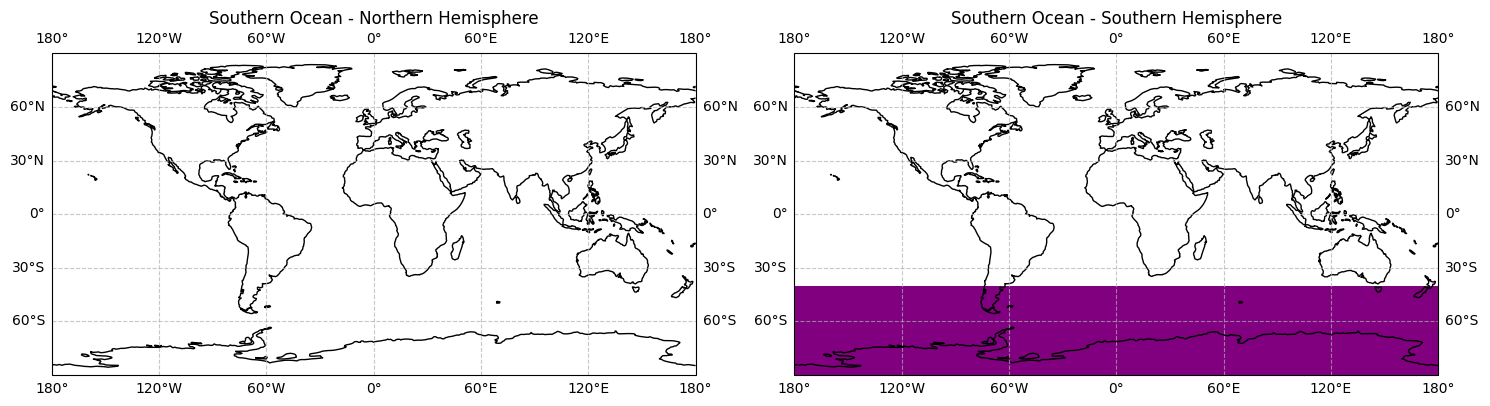

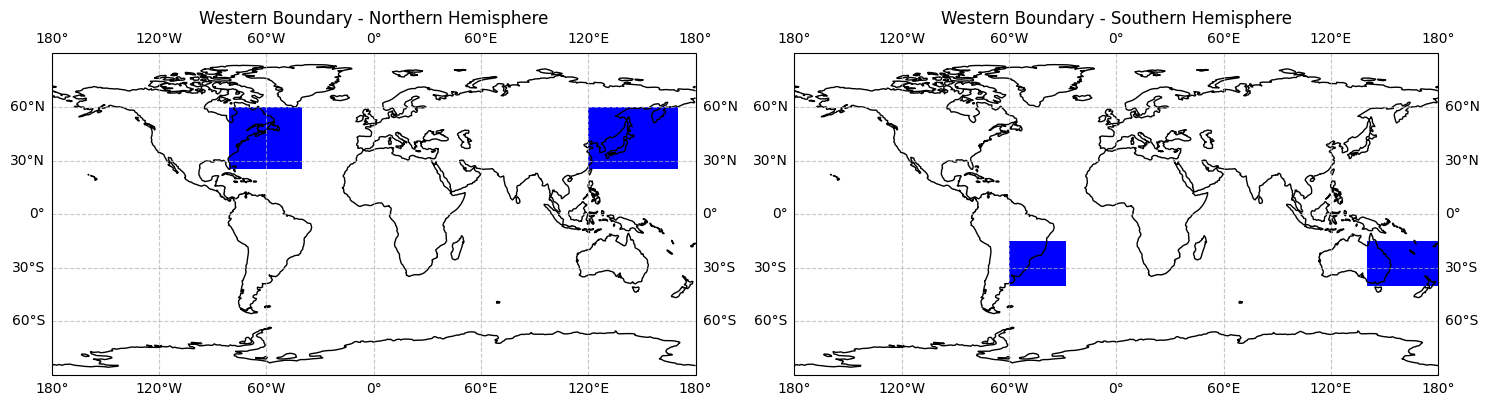

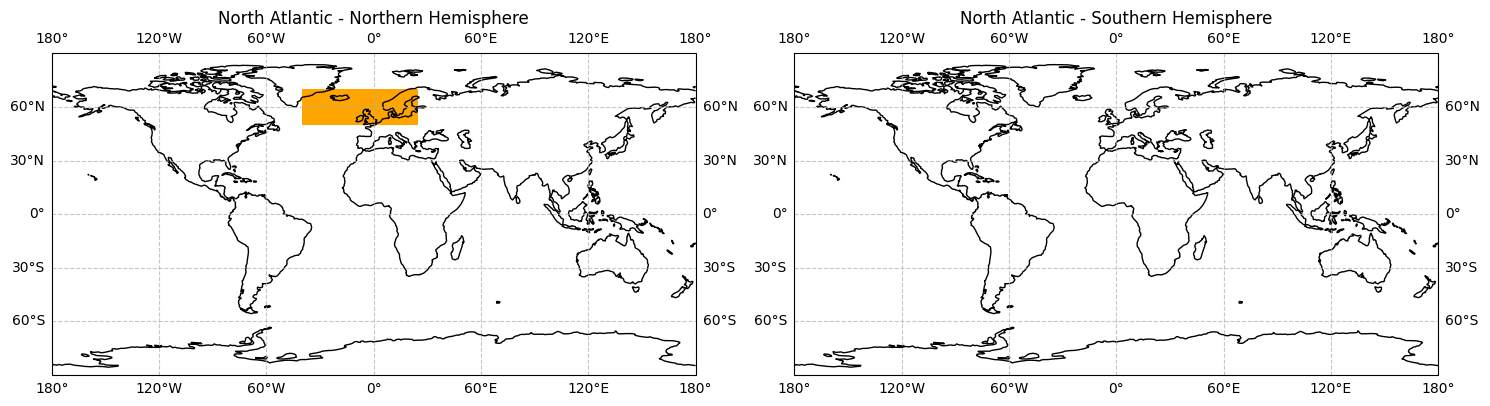

In [10]:
# First, visualize the hemispheric splitting to make sure it works
print("=== VISUALIZING HEMISPHERIC REGIONS ===")
plot_hemispheric_regions_masks(models_dict)


In [ ]:
# Create models dictionary
models_dict = {
    'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),
}

# Quick test with few regions and seasons
print("\n=== QUICK SEASONAL ANALYSIS ===")
seasonal_pdfs, seasonal_thresholds = quick_seasonal_regional_analysis(
    models_dict,
    regions=['equatorial', 'eastern_boundary', 'western_boundary', 'north_atlantic','southern_ocean'],  # Focus on cross-hemisphere regions
    seasons=['DJF', 'JJA'],  # Just summer and winter
    xlim=(-3, 3)
)



=== QUICK SEASONAL ANALYSIS ===
QUICK SEASONAL REGIONAL ANALYSIS
EFFICIENT SEASONAL REGIONAL PDF ANALYSIS
Seasons: ['DJF', 'JJA']
X-axis limits: (-3, 3)
Creating hemispheric masks for OSTIA...
Creating hemispheric masks for ICON...
Creating hemispheric masks for IFS-FESOM...

Processing equatorial...
  Season: DJF
    Model: OSTIA
      north: 110,005,317 points
      south: 111,065,136 points
      Total: 221,070,453 points
      Mean: 0.045, Std: 0.731
    Model: ICON
      north: 111,470,886 points
      south: 110,300,703 points
      Total: 221,771,589 points
      Mean: 0.123, Std: 0.696
    Model: IFS-FESOM
      north: 111,166,048 points
      south: 110,034,120 points
      Total: 221,200,168 points
      Mean: 0.112, Std: 0.858
  Season: JJA
    Model: OSTIA
      north: 112,242,024 points
      south: 113,323,392 points
      Total: 225,565,416 points
      Mean: 0.070, Std: 0.648
    Model: ICON
      north: 113,737,392 points
      south: 112,543,416 points
      Total: 2

In [ ]:

# Full analysis with all seasons
print("\n=== FULL SEASONAL ANALYSIS ===")
seasonal_pdfs, seasonal_thresholds = analyze_seasonal_regional_pdfs_efficient(
    models_dict,
    regions=['equatorial', 'eastern_boundary', 'western_boundary', 'north_atlantic'],
    seasons=['DJF', 'MAM', 'JJA', 'SON'],
    xlim=(-2, 2),
    plot_percentile_lines=True,
    percentiles=[90, 95, 99]
)

In [9]:
# Create models dictionary
models_dict = {
    'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),
}



11. Regional Points Above Threshold Analysis
REGIONAL POINTS ABOVE THRESHOLD ANALYSIS
Creating model-specific masks...
Creating masks for OSTIA...
  OSTIA grid: (720,) x (1440,)
Creating masks for ICON...
  ICON grid: (721,) x (1440,)
Creating masks for IFS-FESOM...
  IFS-FESOM grid: (721,) x (1440,)
Computing regional thresholds and counting points above thresholds...

Processing equatorial...
  OSTIA...
    136,211 points
  ICON...
    136,643 points
  IFS-FESOM...
    136,207 points

Processing southern_ocean...
  OSTIA...
    180,841 points
  ICON...
    181,061 points
  IFS-FESOM...
    181,287 points

Processing eastern_boundary...
  OSTIA...
    61,736 points
  ICON...
    61,579 points
  IFS-FESOM...
    61,344 points

Processing western_boundary...
  OSTIA...
    59,575 points
  ICON...
    59,119 points
  IFS-FESOM...
    58,956 points

Processing north_atlantic...
  OSTIA...
    16,041 points
  ICON...
    15,772 points
  IFS-FESOM...
    15,618 points

--- Equatorial Regio

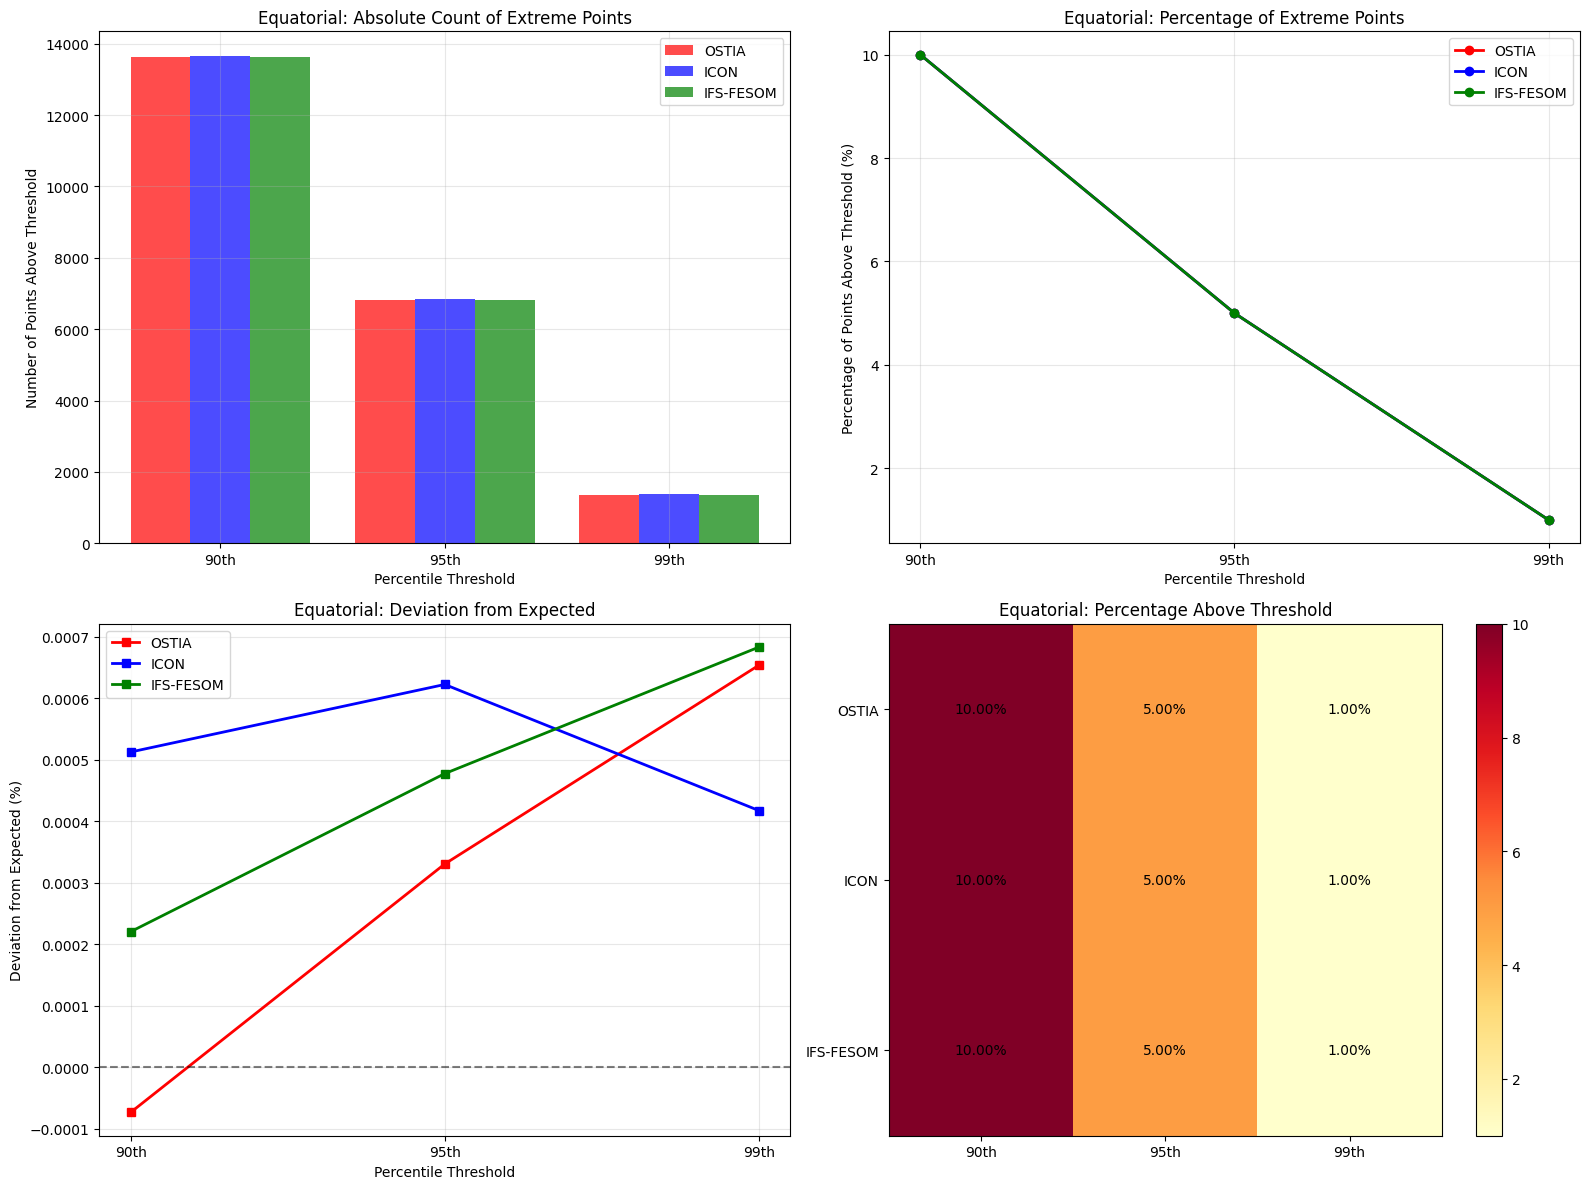


Equatorial Region Analysis:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      0.167 |          13,621 |    10.000% |      10.0% |    -0.000%
             |         95 |      0.194 |           6,811 |     5.000% |       5.0% |    +0.000%
             |         99 |      0.251 |           1,363 |     1.001% |       1.0% |    +0.001%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |         90 |      0.218 |          13,665 |    10.001% |      10.0% |    +0.001%
             |         95 |      0.239 |           6,833 |     5.001% |       5.0% |    +0.001%
           

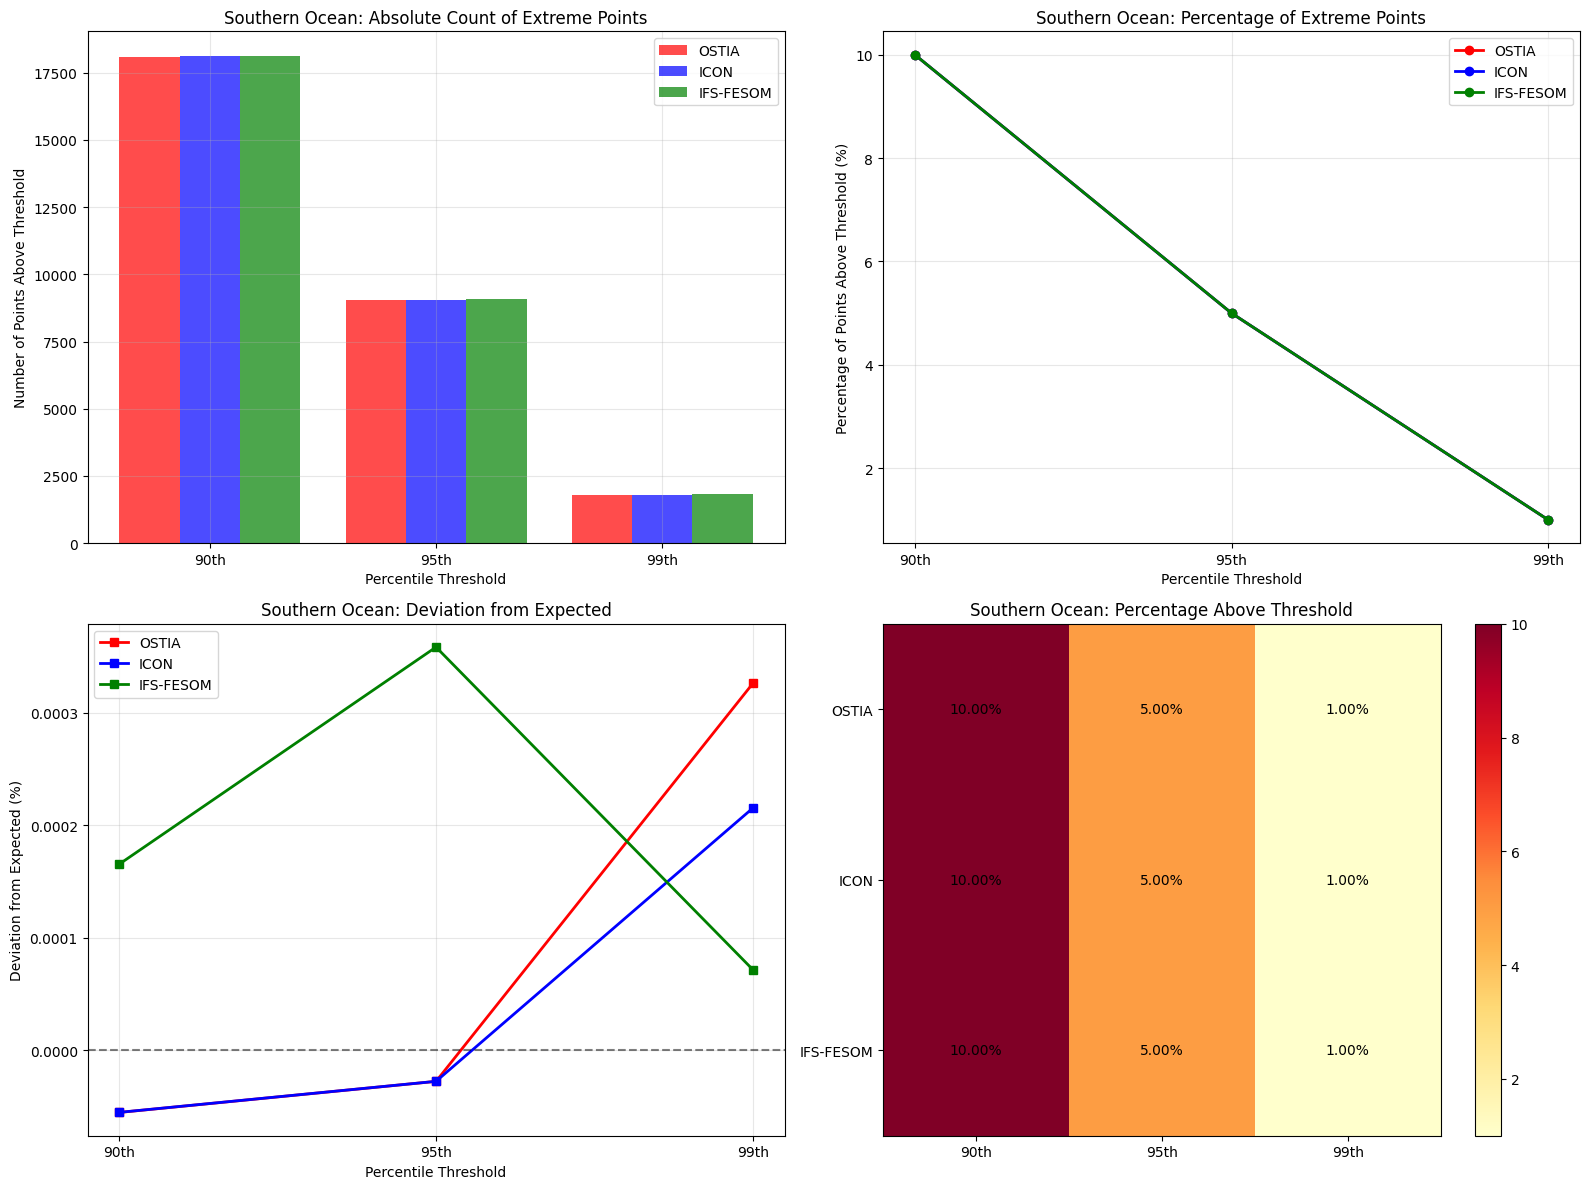


Southern Ocean Region Analysis:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      0.129 |          18,084 |    10.000% |      10.0% |    -0.000%
             |         95 |      0.176 |           9,042 |     5.000% |       5.0% |    -0.000%
             |         99 |      0.264 |           1,809 |     1.000% |       1.0% |    +0.000%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |         90 |      0.195 |          18,106 |    10.000% |      10.0% |    -0.000%
             |         95 |      0.246 |           9,053 |     5.000% |       5.0% |    -0.000%
       

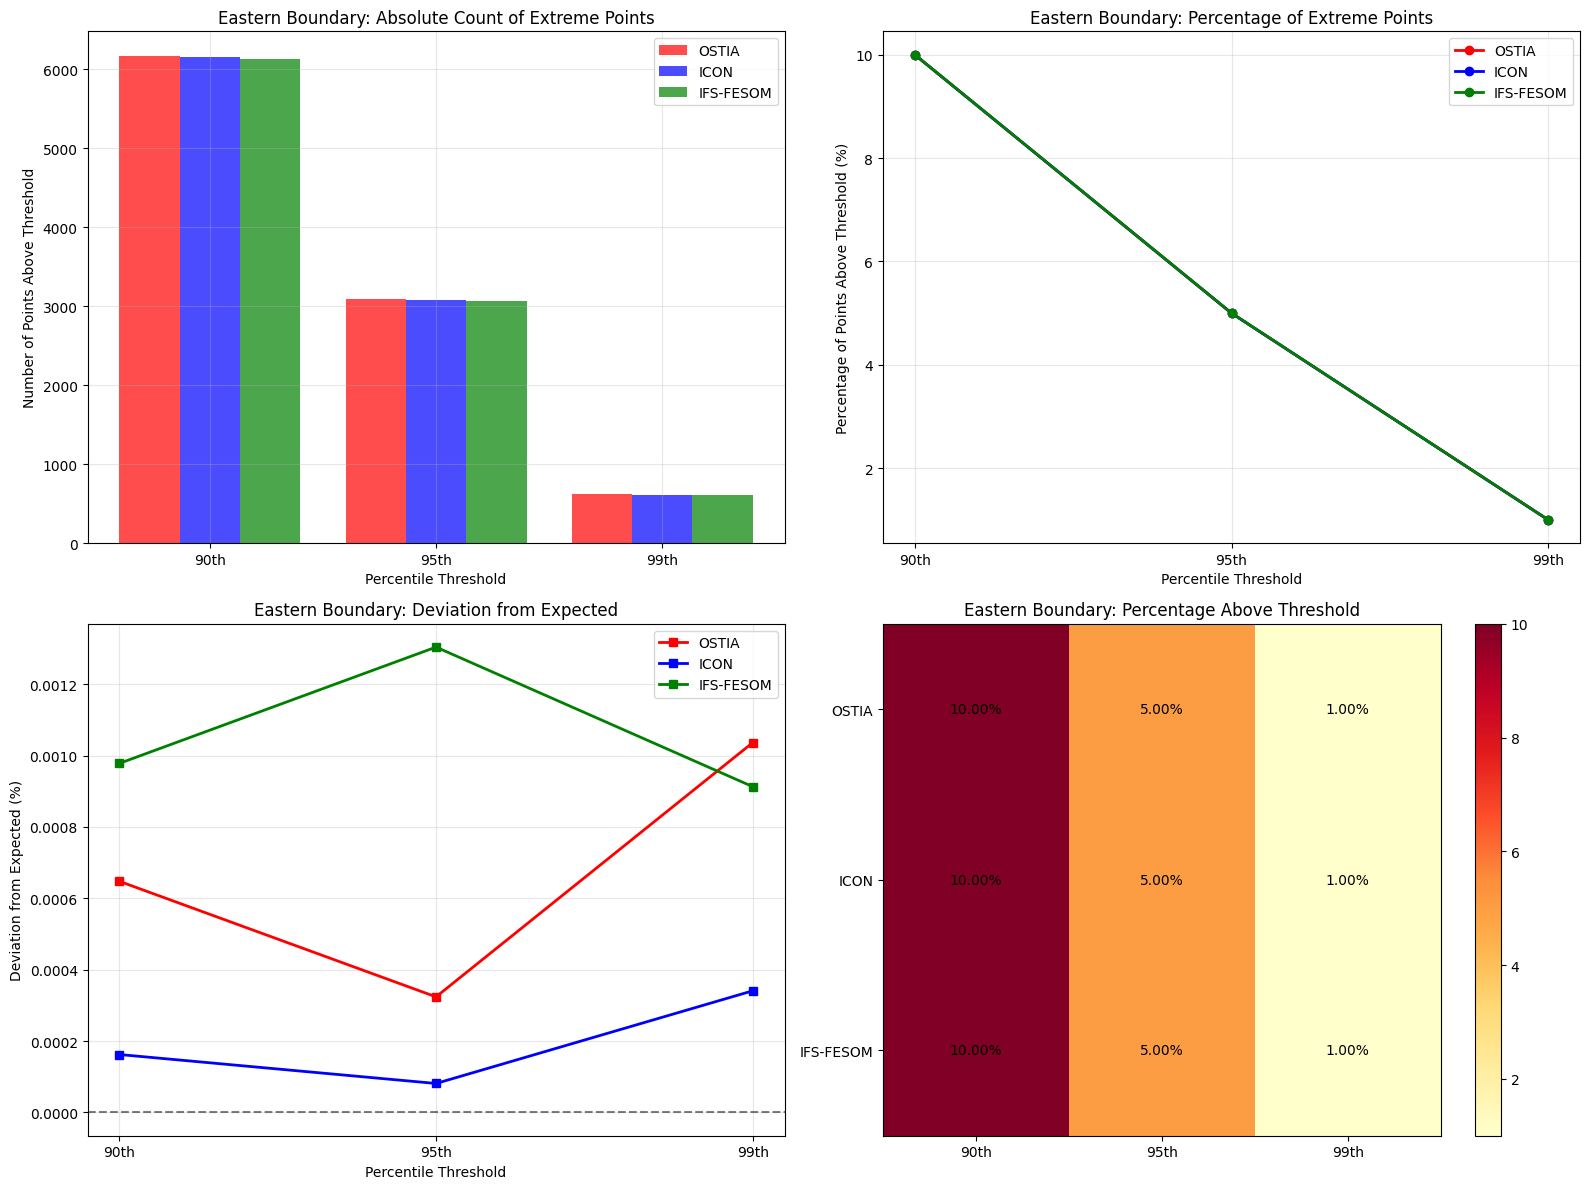


Eastern Boundary Region Analysis:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      0.250 |           6,174 |    10.001% |      10.0% |    +0.001%
             |         95 |      0.311 |           3,087 |     5.000% |       5.0% |    +0.000%
             |         99 |      0.402 |             618 |     1.001% |       1.0% |    +0.001%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |         90 |      0.443 |           6,158 |    10.000% |      10.0% |    +0.000%
             |         95 |      0.563 |           3,079 |     5.000% |       5.0% |    +0.000%
     

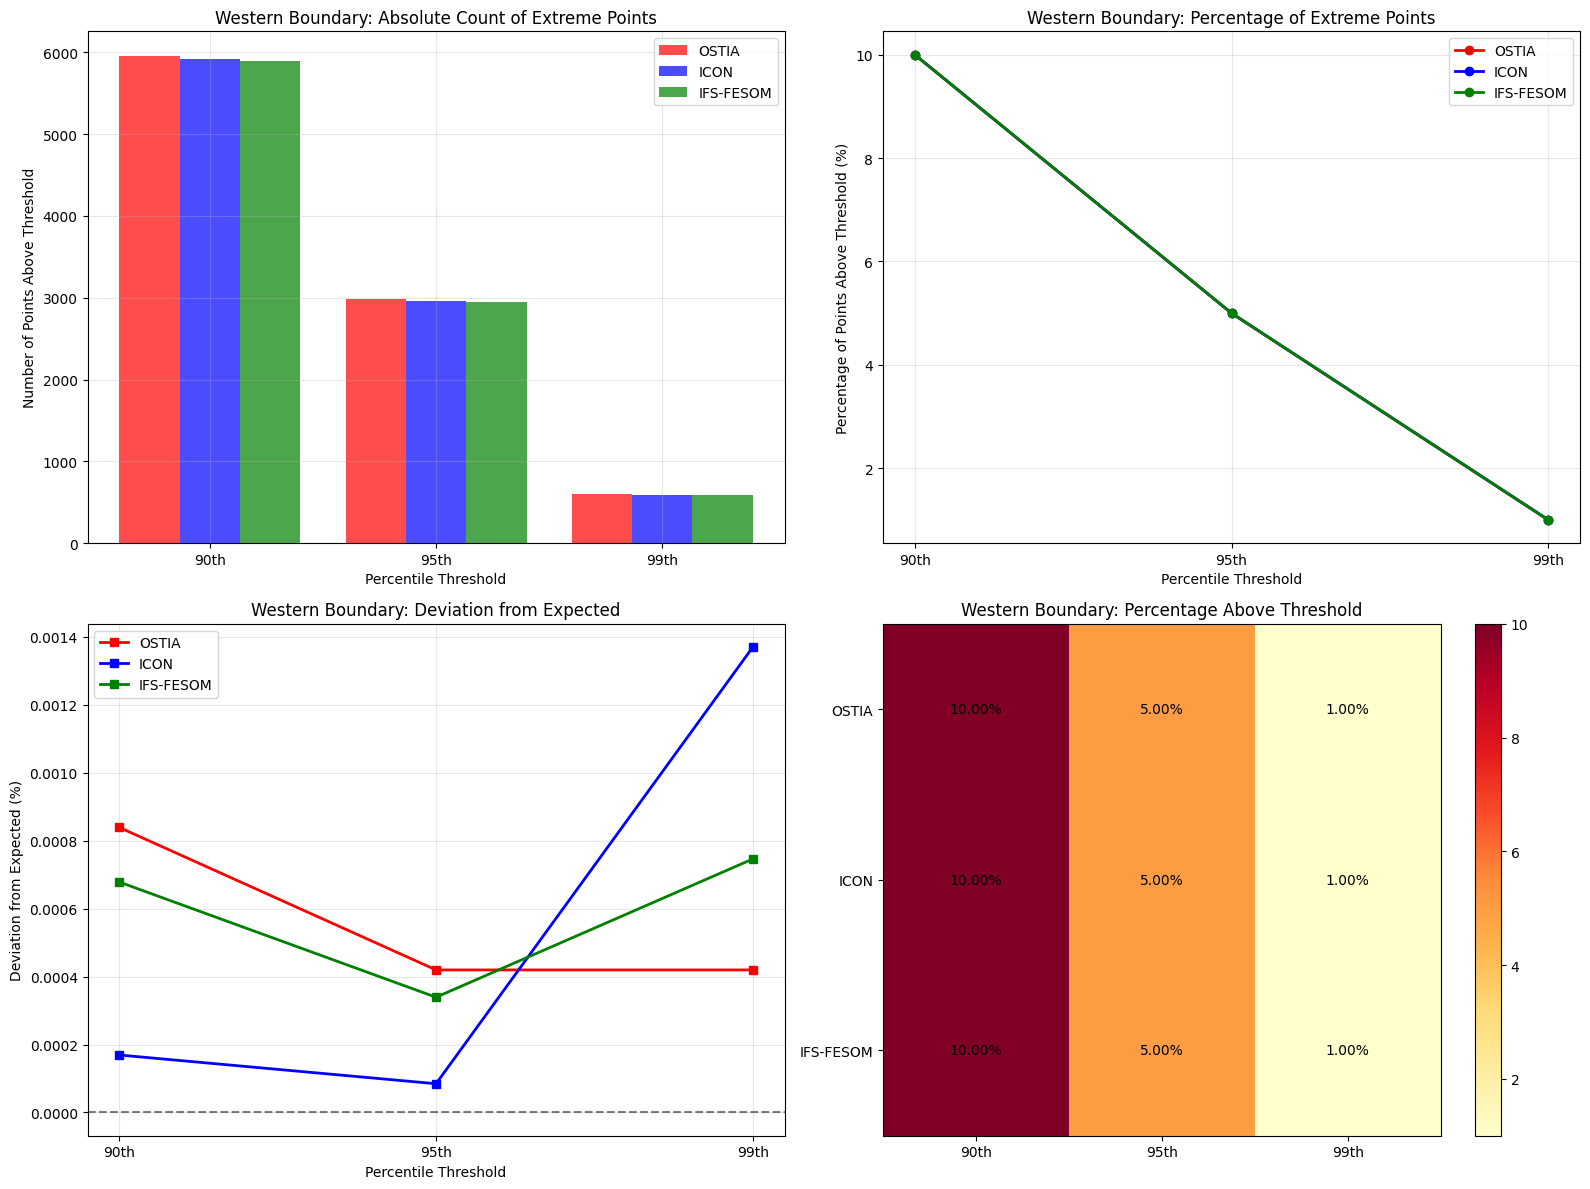


Western Boundary Region Analysis:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      0.382 |           5,958 |    10.001% |      10.0% |    +0.001%
             |         95 |      0.496 |           2,979 |     5.000% |       5.0% |    +0.000%
             |         99 |      0.612 |             596 |     1.000% |       1.0% |    +0.000%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |         90 |      0.338 |           5,912 |    10.000% |      10.0% |    +0.000%
             |         95 |      0.424 |           2,956 |     5.000% |       5.0% |    +0.000%
     

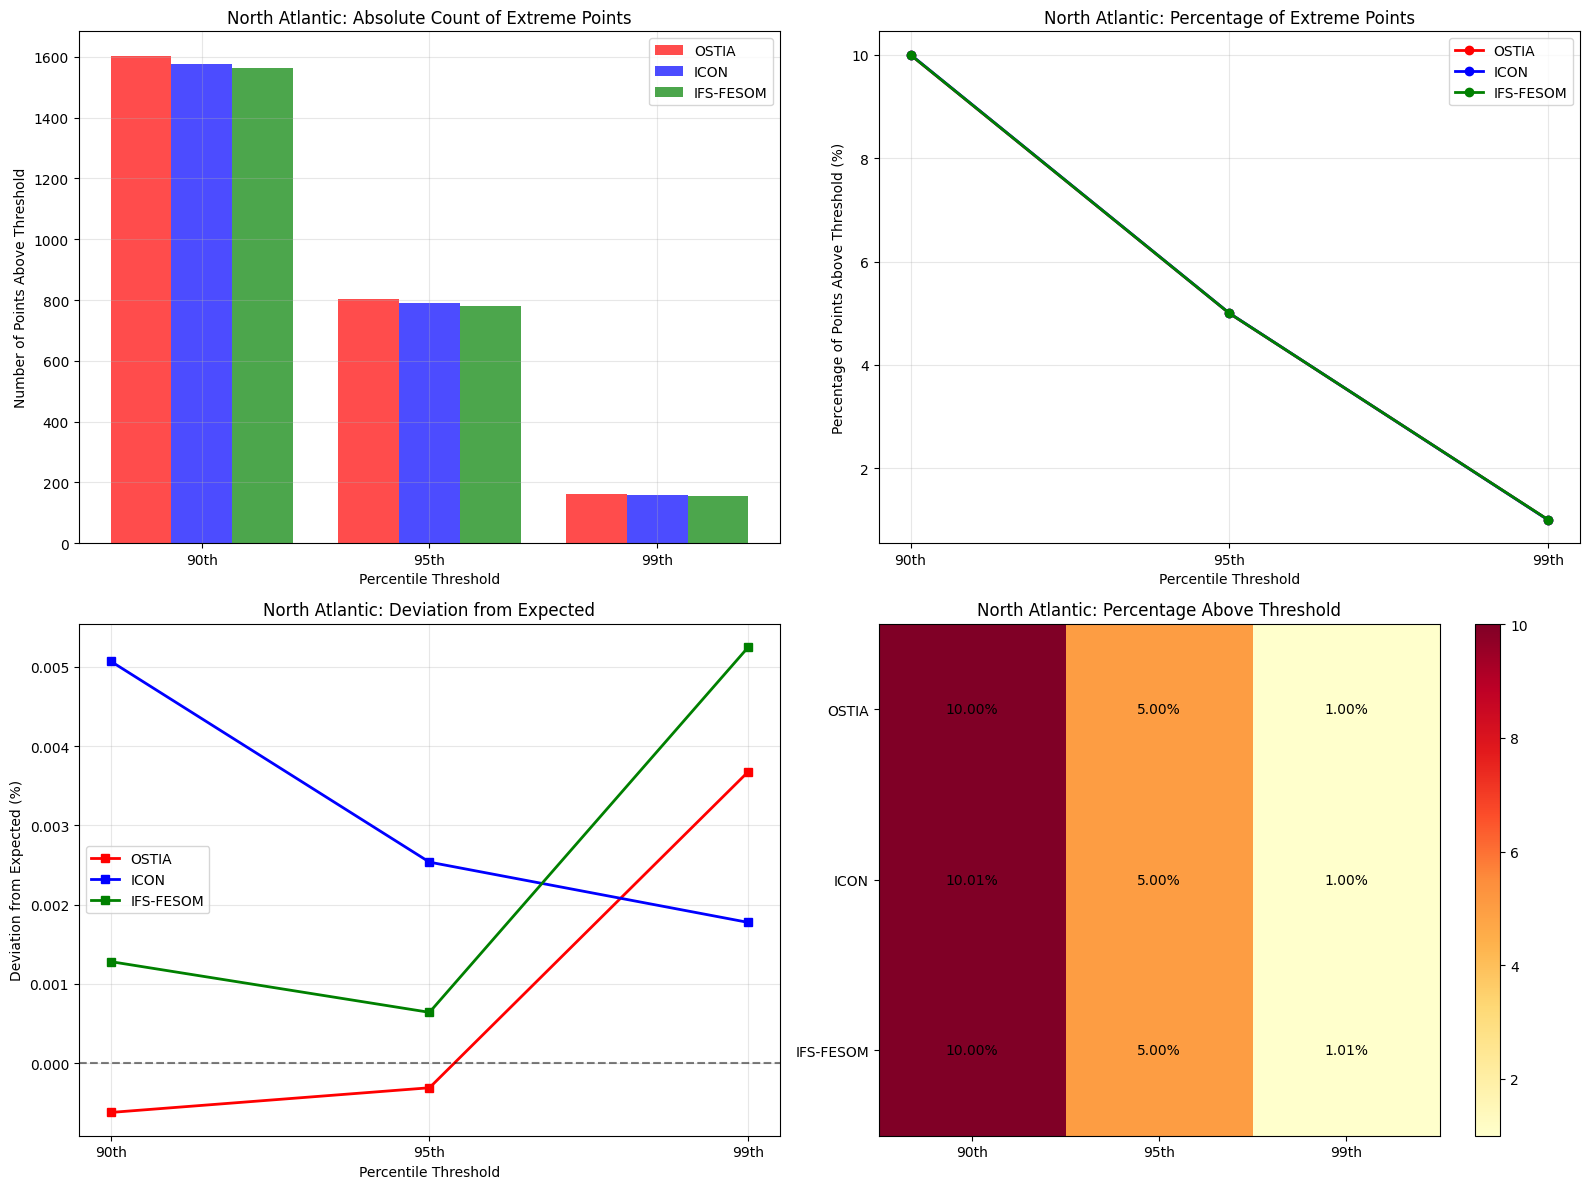


North Atlantic Region Analysis:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      0.539 |           1,604 |     9.999% |      10.0% |    -0.001%
             |         95 |      0.589 |             802 |     5.000% |       5.0% |    -0.000%
             |         99 |      0.644 |             161 |     1.004% |       1.0% |    +0.004%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |         90 |      0.295 |           1,578 |    10.005% |      10.0% |    +0.005%
             |         95 |      0.334 |             789 |     5.003% |       5.0% |    +0.003%
       

In [9]:
# 1. Use the NEW regional points above threshold analysis
print("\n11. Regional Points Above Threshold Analysis")
regional_points_results = analyze_regional_points_above_thresholds(
    models_dict,
    regions=None,
    percentiles=[90, 95, 99]
)



7. Multi-Model Regional Comparison (No Percentile Lines)
REGIONAL EXTREME DETECTION THRESHOLD ANALYSIS
Using xlim: [-1, 0.75]
Plot percentile lines: False
Creating model-specific masks...
Creating masks for OSTIA...
  OSTIA grid: (720,) x (1440,)
Creating masks for ICON...
  ICON grid: (721,) x (1440,)
Creating masks for IFS-FESOM...
  IFS-FESOM grid: (721,) x (1440,)
Computing regional thresholds and PDFs...

Processing equatorial...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing eastern_boundary...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing north_atlantic...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing southern_ocean...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing western_boundary...
  OSTIA...
  ICON...
  IFS-FESOM...


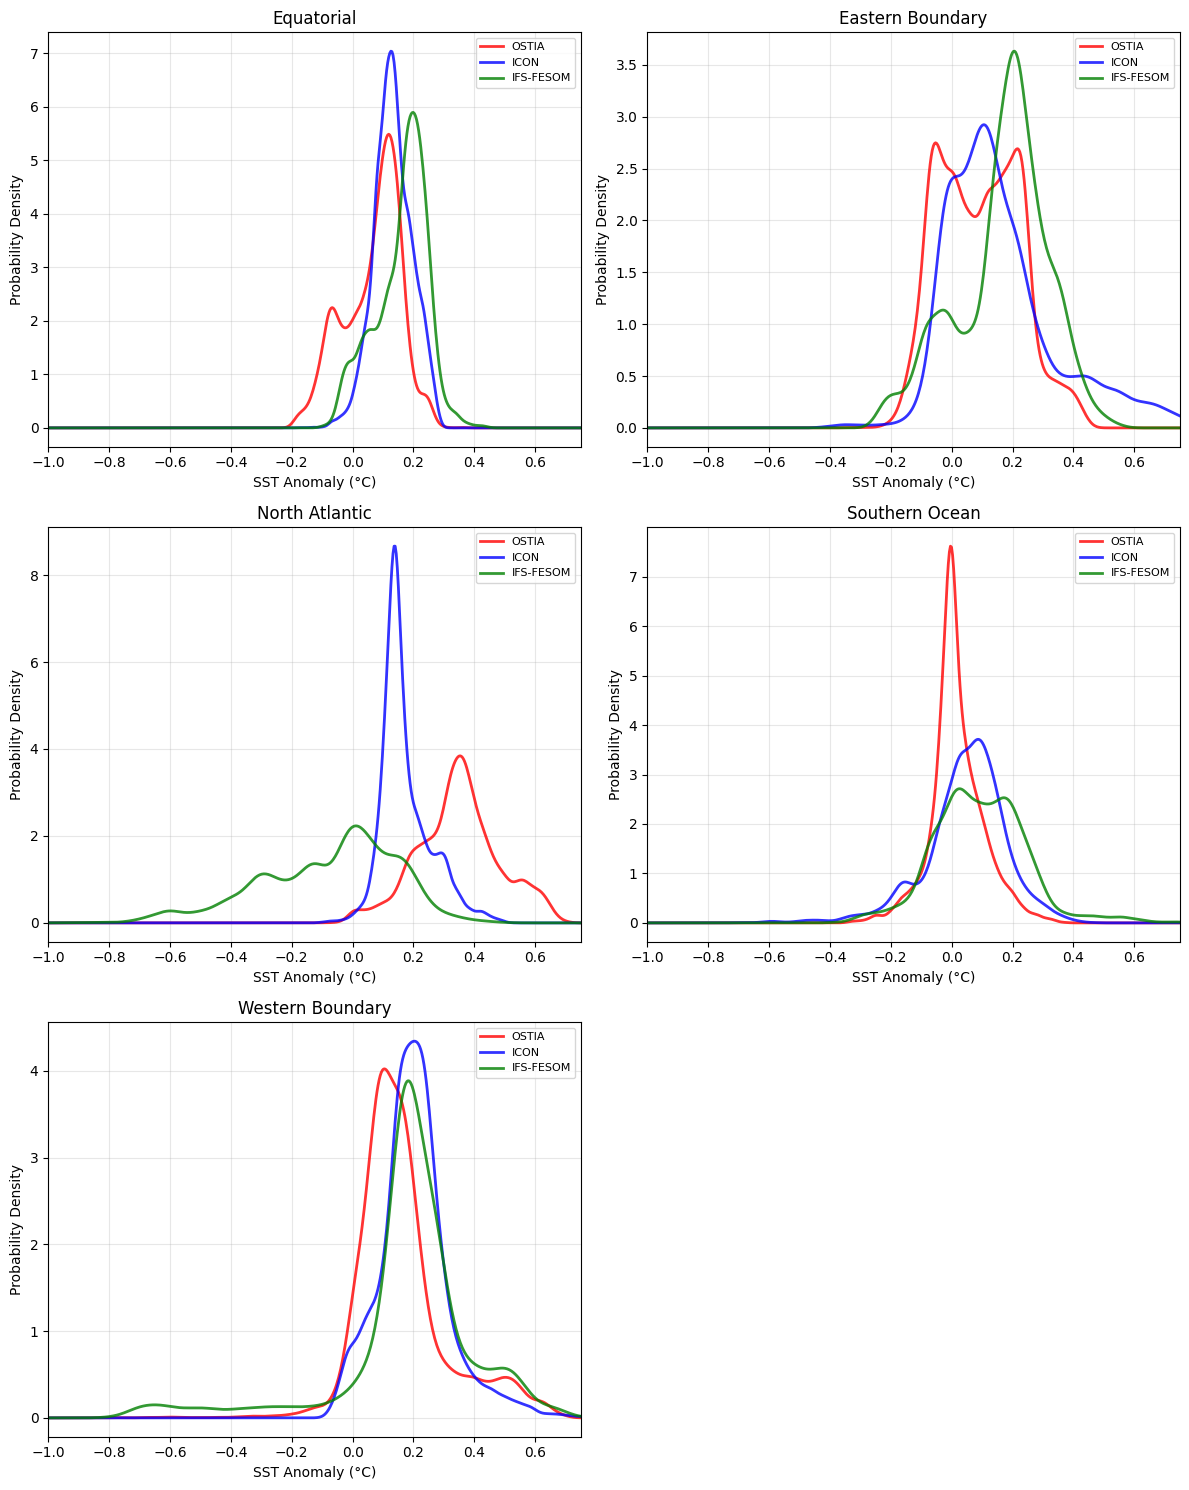

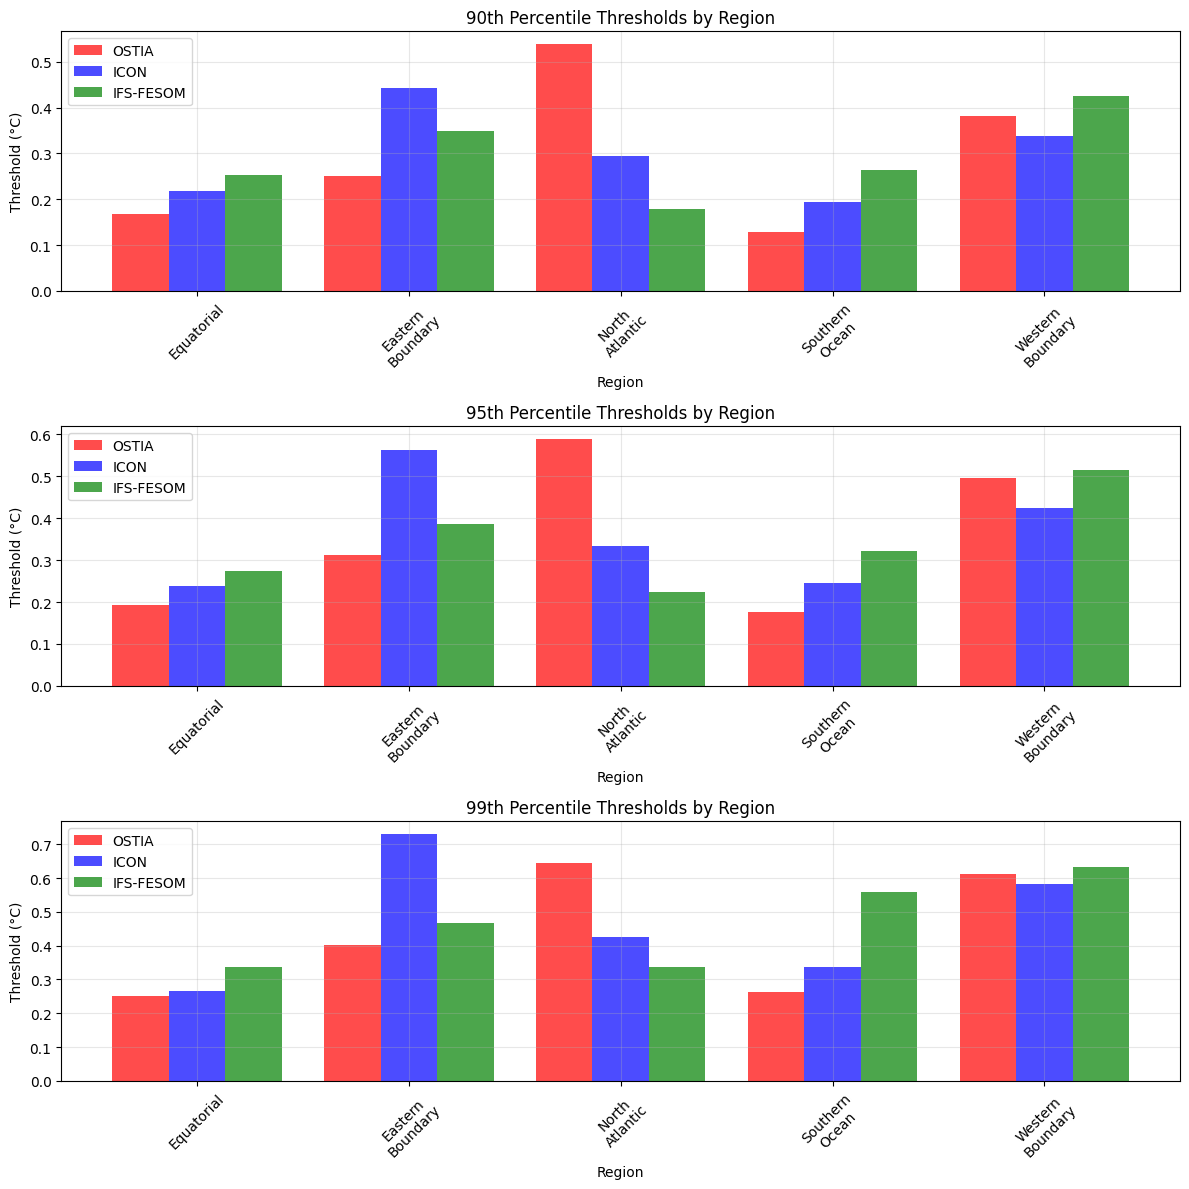


REGIONAL THRESHOLD COMPARISON:

90th Percentile Thresholds (°C):
Region               |      OSTIA |       ICON |  IFS-FESOM
-----------------------------------------------------------
Equatorial           |      0.167 |      0.218 |      0.253 | 
Eastern Boundary     |      0.250 |      0.443 |      0.348 | 
North Atlantic       |      0.539 |      0.295 |      0.179 | 
Southern Ocean       |      0.129 |      0.195 |      0.264 | 
Western Boundary     |      0.382 |      0.338 |      0.426 | 

95th Percentile Thresholds (°C):
Region               |      OSTIA |       ICON |  IFS-FESOM
-----------------------------------------------------------
Equatorial           |      0.194 |      0.239 |      0.274 | 
Eastern Boundary     |      0.311 |      0.563 |      0.387 | 
North Atlantic       |      0.589 |      0.334 |      0.224 | 
Southern Ocean       |      0.176 |      0.246 |      0.321 | 
Western Boundary     |      0.496 |      0.424 |      0.514 | 

99th Percentile Thresholds (°

In [10]:

# 2. Use the MODIFIED regional extreme threshold analysis with optional percentile lines
print("\n7. Multi-Model Regional Comparison (No Percentile Lines)")
regional_thresholds, regional_pdfs, regional_masks = analyze_regional_extreme_thresholds(
    models_dict,
    regions=['equatorial', 'eastern_boundary', 'north_atlantic', 'southern_ocean', 'western_boundary'],
    percentiles=[90, 95, 99],
    xlim=(-1, 0.75),
    plot_percentile_lines=False  # Set to False to hide percentile lines
)



7. Multi-Model Regional Comparison (With Percentile Lines)
REGIONAL EXTREME DETECTION THRESHOLD ANALYSIS
Using xlim: [-1, 0.75]
Plot percentile lines: True
Creating model-specific masks...
Creating masks for OSTIA...
  OSTIA grid: (720,) x (1440,)
Creating masks for ICON...
  ICON grid: (721,) x (1440,)
Creating masks for IFS-FESOM...
  IFS-FESOM grid: (721,) x (1440,)
Computing regional thresholds and PDFs...

Processing equatorial...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing eastern_boundary...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing north_atlantic...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing southern_ocean...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing western_boundary...
  OSTIA...
  ICON...
  IFS-FESOM...


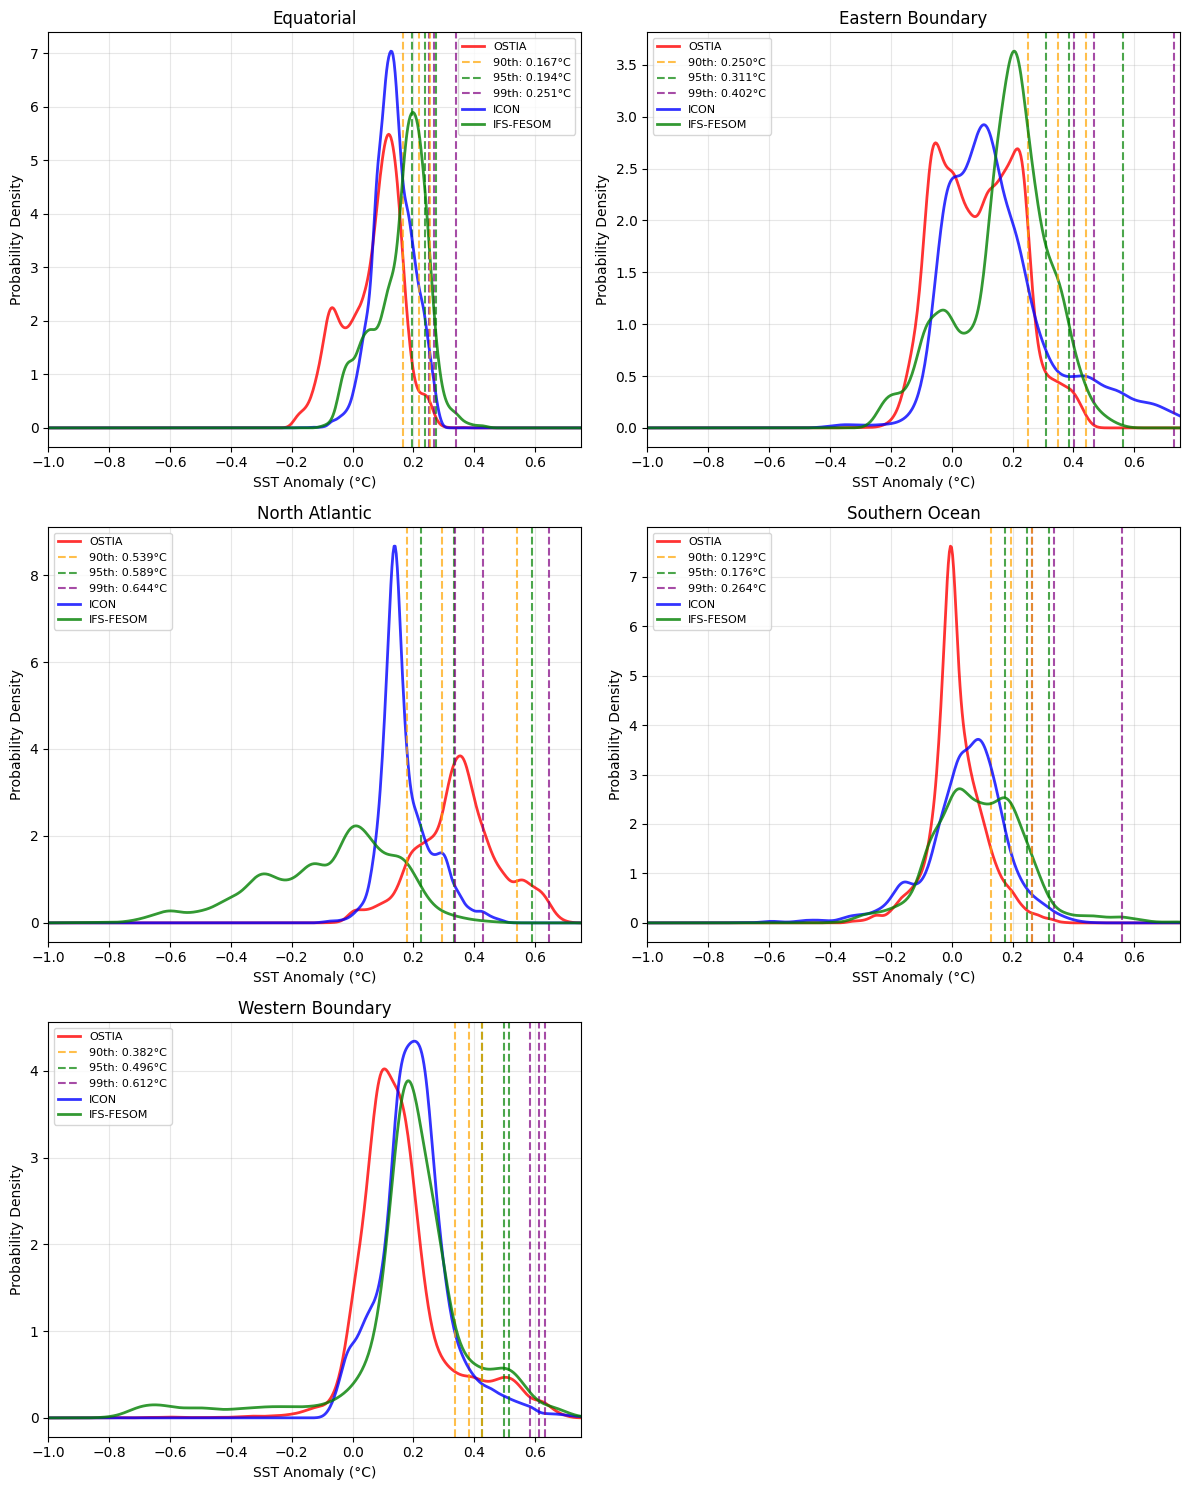

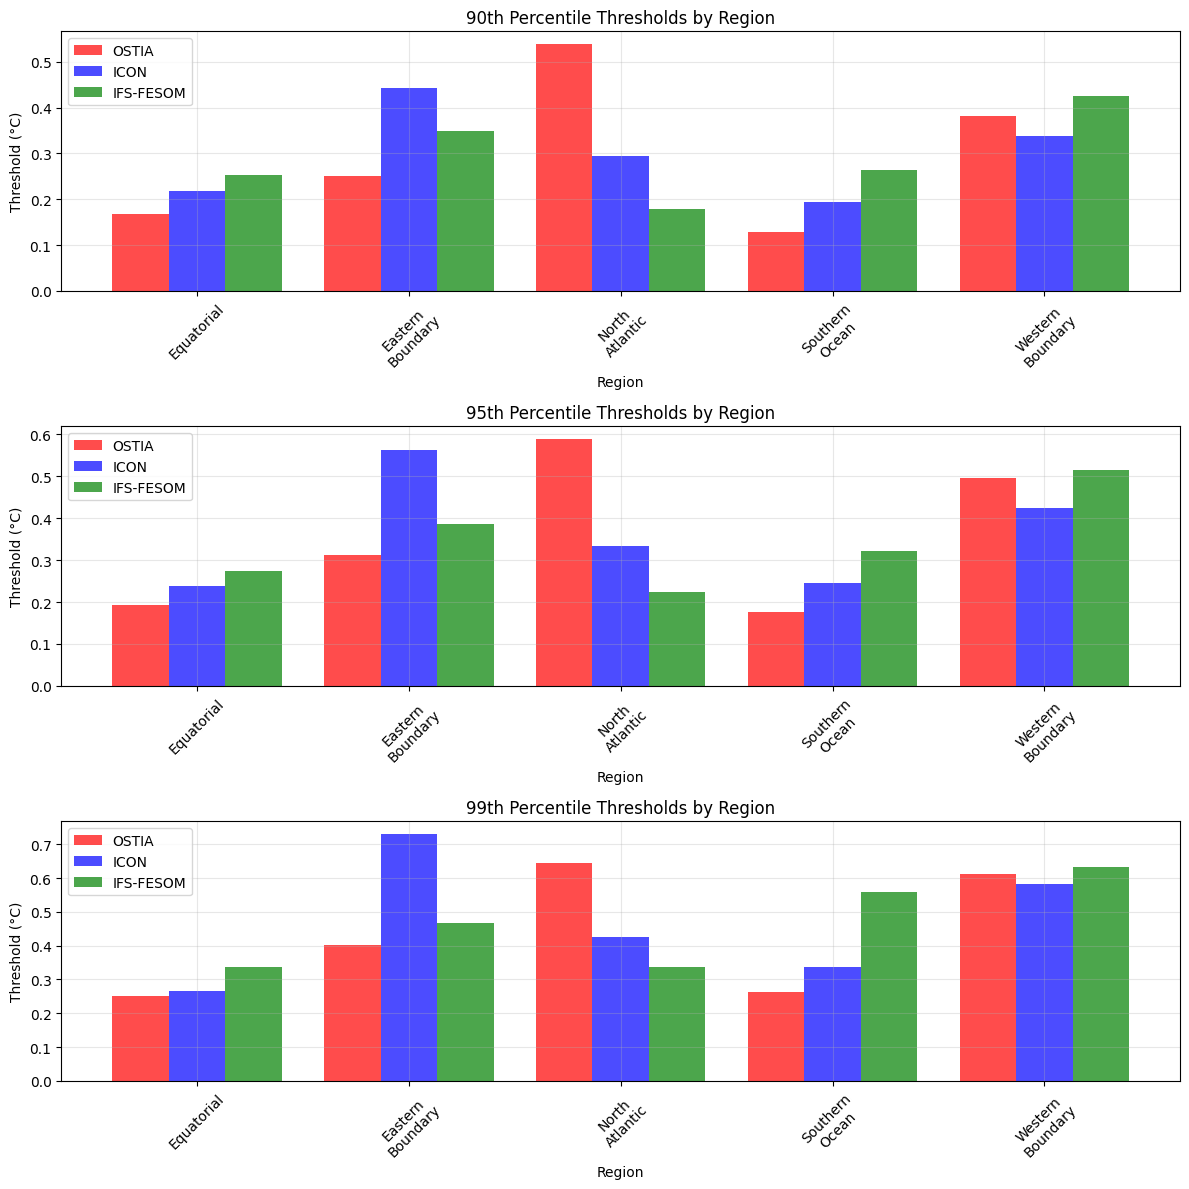


REGIONAL THRESHOLD COMPARISON:

90th Percentile Thresholds (°C):
Region               |      OSTIA |       ICON |  IFS-FESOM
-----------------------------------------------------------
Equatorial           |      0.167 |      0.218 |      0.253 | 
Eastern Boundary     |      0.250 |      0.443 |      0.348 | 
North Atlantic       |      0.539 |      0.295 |      0.179 | 
Southern Ocean       |      0.129 |      0.195 |      0.264 | 
Western Boundary     |      0.382 |      0.338 |      0.426 | 

95th Percentile Thresholds (°C):
Region               |      OSTIA |       ICON |  IFS-FESOM
-----------------------------------------------------------
Equatorial           |      0.194 |      0.239 |      0.274 | 
Eastern Boundary     |      0.311 |      0.563 |      0.387 | 
North Atlantic       |      0.589 |      0.334 |      0.224 | 
Southern Ocean       |      0.176 |      0.246 |      0.321 | 
Western Boundary     |      0.496 |      0.424 |      0.514 | 

99th Percentile Thresholds (°

In [11]:

# Or with percentile lines:
print("\n7. Multi-Model Regional Comparison (With Percentile Lines)")
regional_thresholds, regional_pdfs, regional_masks = analyze_regional_extreme_thresholds(
    models_dict,
    regions=['equatorial', 'eastern_boundary', 'north_atlantic', 'southern_ocean', 'western_boundary'],
    percentiles=[90, 95, 99],
    xlim=(-1, 0.75),
    plot_percentile_lines=True  # Set to True to show percentile lines (default)
)

=== DV8 FUNCTIONS DEMONSTRATION ===

1. Creating Oceanic Regions Mask


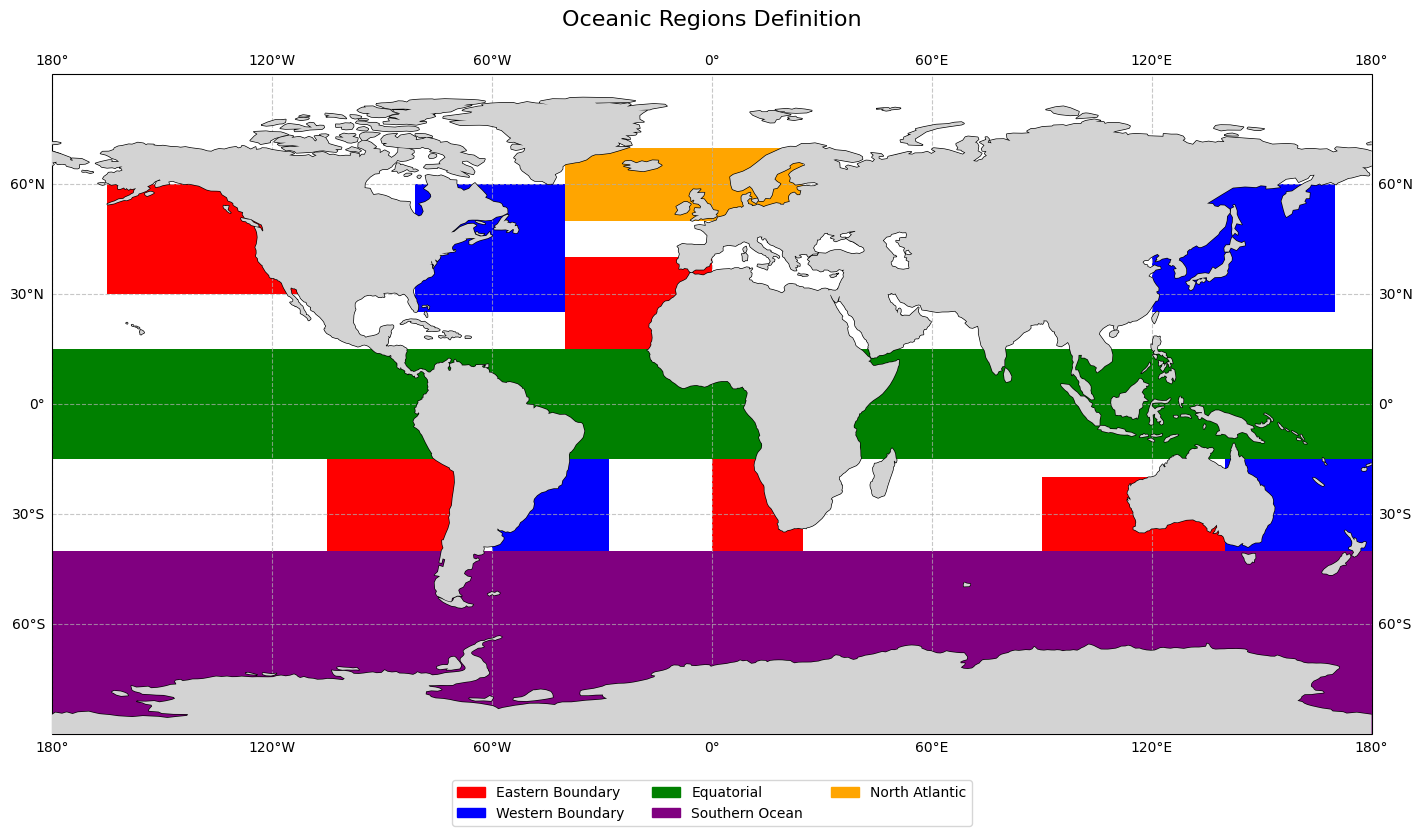

In [7]:


print("=== DV8 FUNCTIONS DEMONSTRATION ===")

# Example 1: Basic mask creation and visualization
print("\n1. Creating Oceanic Regions Mask")
lats = models_dict['OSTIA'][0].lat.values
lons = models_dict['OSTIA'][0].lon.values
masks = create_oceanic_regions_mask(lats, lons)

# Visualize the masks
fig, ax = plot_region_masks(lats, lons, masks, title="Oceanic Regions Definition")
plt.show()

In [8]:
# Example 2: Extract and analyze region data
print("\n2. Extracting Region Data")
ostia_data = models_dict['OSTIA'][0]['dat_anomaly'].values
region_data = extract_region_data(ostia_data, lats, lons, masks)

print("Data points per region:")
for region, data in region_data.items():
    print(f"  {region}: {len(data)} points")


2. Extracting Region Data
Data points per region:
  equatorial: 1135814400 points
  southern_ocean: 1893024000 points
  eastern_boundary: 546873600 points
  western_boundary: 524262480 points
  north_atlantic: 136718400 points



3. Computing Basic PDFs


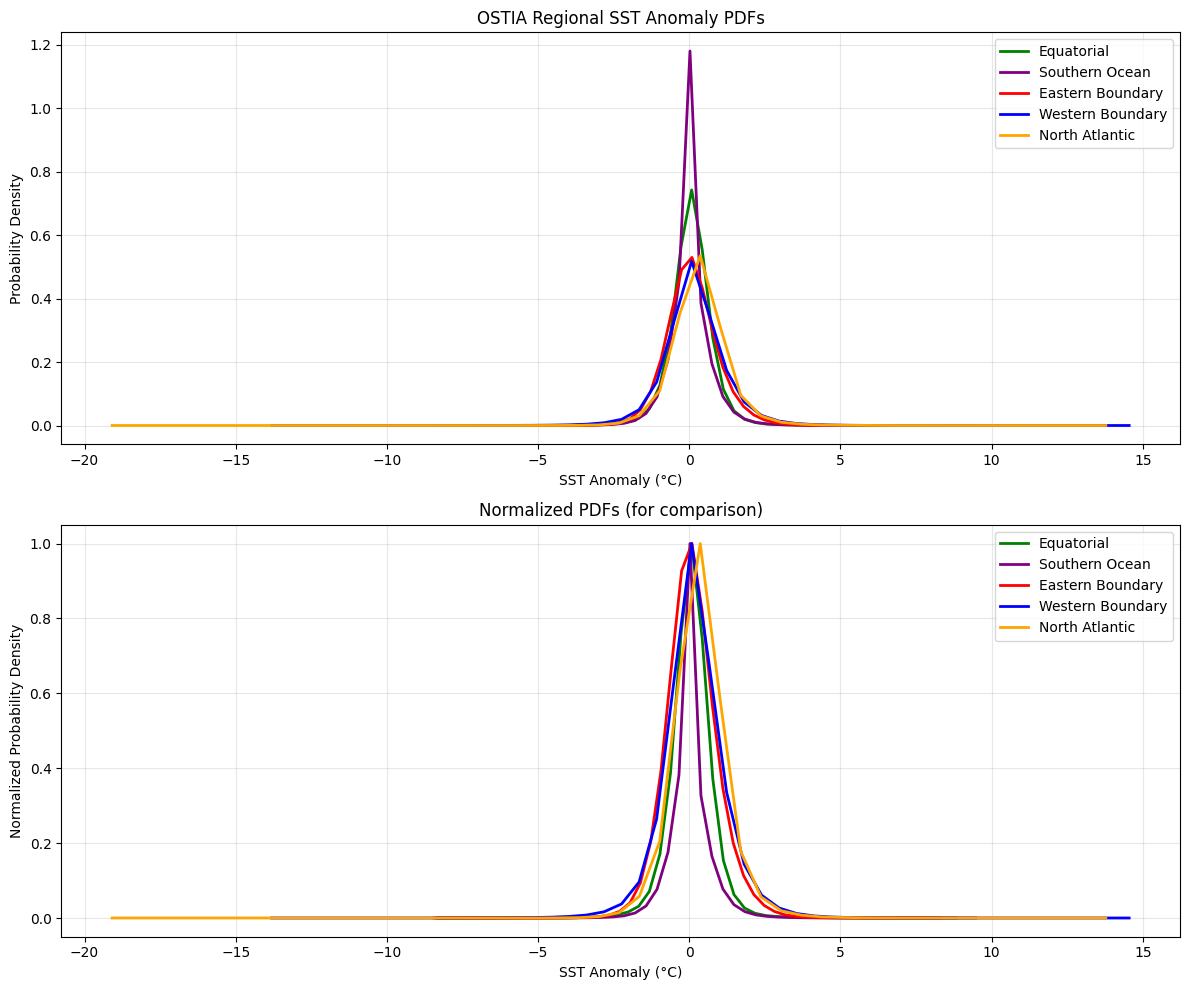

In [9]:
# Example 3: Compute basic PDFs
print("\n3. Computing Basic PDFs")
pdfs, stats = compute_pdfs(region_data, bins=50, density=True)

# Plot the PDFs
fig, (ax1, ax2) = plot_region_pdfs(pdfs, xlabel="SST Anomaly (°C)", 
                                  title="OSTIA Regional SST Anomaly PDFs")
plt.show()


4. Regional Statistics


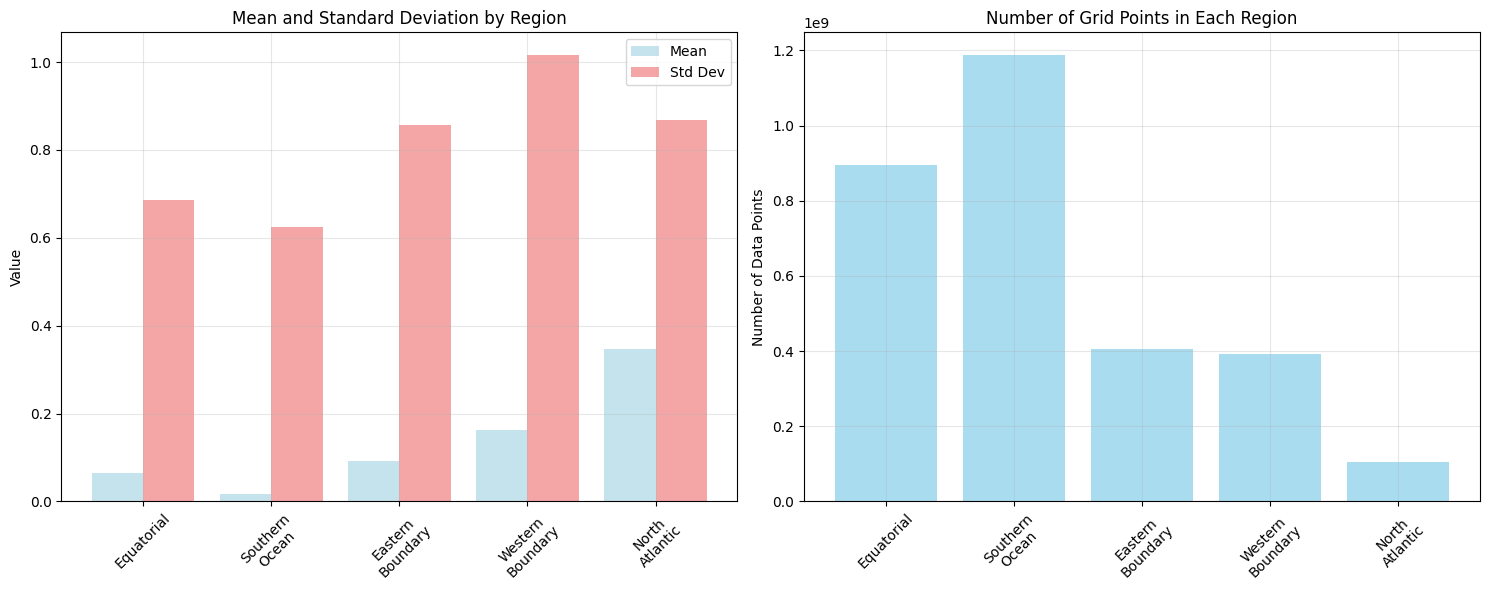


5. Improved PDF Computation with Tail Handling
Computing PDFs for OSTIA - SST Anomaly
Trimming 1% from each tail for better visualization


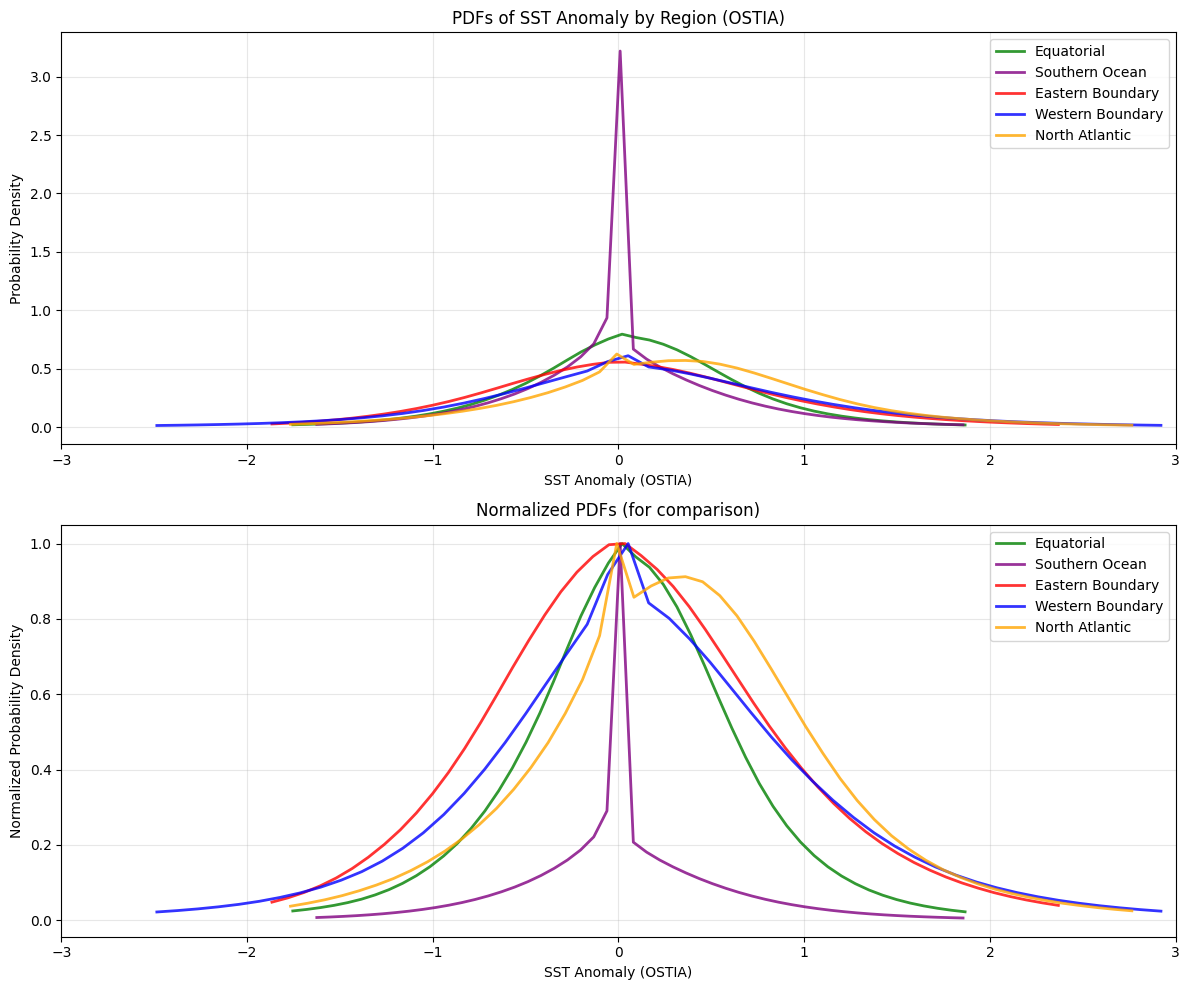

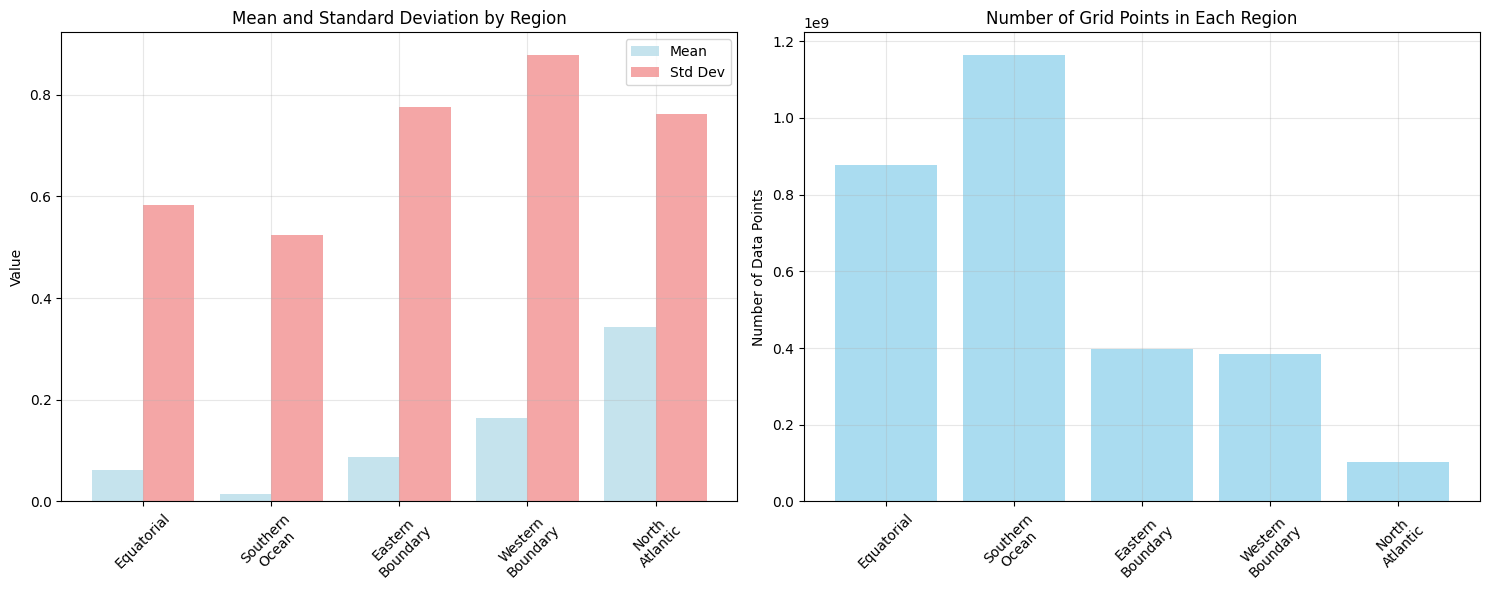


OSTIA - SST Anomaly Region Statistics:
(Tails trimmed: 1% from each side)
Equatorial           | Mean:   0.063 | Std:  0.584 | Points: 877,408,619
Southern Ocean       | Mean:   0.015 | Std:  0.524 | Points: 1,164,894,515
Eastern Boundary     | Mean:   0.087 | Std:  0.776 | Points: 397,674,937
Western Boundary     | Mean:   0.164 | Std:  0.879 | Points: 383,754,737
North Atlantic       | Mean:   0.342 | Std:  0.763 | Points: 103,328,739


In [10]:
# Example 4: Plot regional statistics
print("\n4. Regional Statistics")
fig, (ax1, ax2) = plot_region_statistics(stats)
plt.show()

# Example 5: Compute PDFs for specific variable with improved method
print("\n5. Improved PDF Computation with Tail Handling")
pdfs_improved, stats_improved = compute_pdfs_for_variable_improved(
    ostia_data, lats, lons, masks, "SST Anomaly", "OSTIA",
    trim_tails=True, tail_percentile=1, xlim=(-3, 3)
)

In [11]:
# Example 6: Robust PDF computation
print("\n6. Robust PDF Computation")
pdfs_robust, stats_robust = compute_pdfs_robust(
    region_data, bins=50, density=True, 
    trim_tails=True, tail_percentile=1
)


6. Robust PDF Computation



7. Multi-Model Regional Comparison
Creating model-specific masks...
Creating masks for OSTIA...
  OSTIA grid: (720,) x (1440,)
Creating masks for ICON...
  ICON grid: (721,) x (1440,)
Creating masks for IFS-FESOM...
  IFS-FESOM grid: (721,) x (1440,)
REGIONAL EXTREME DETECTION THRESHOLD ANALYSIS
Using xlim: [-1, 0.75]
Creating model-specific masks...
Creating masks for OSTIA...
  OSTIA grid: (720,) x (1440,)
Creating masks for ICON...
  ICON grid: (721,) x (1440,)
Creating masks for IFS-FESOM...
  IFS-FESOM grid: (721,) x (1440,)
Computing regional thresholds and PDFs...

Processing equatorial...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing eastern_boundary...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing north_atlantic...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing southern_ocean...
  OSTIA...
  ICON...
  IFS-FESOM...

Processing western_boundary...
  OSTIA...
  ICON...
  IFS-FESOM...


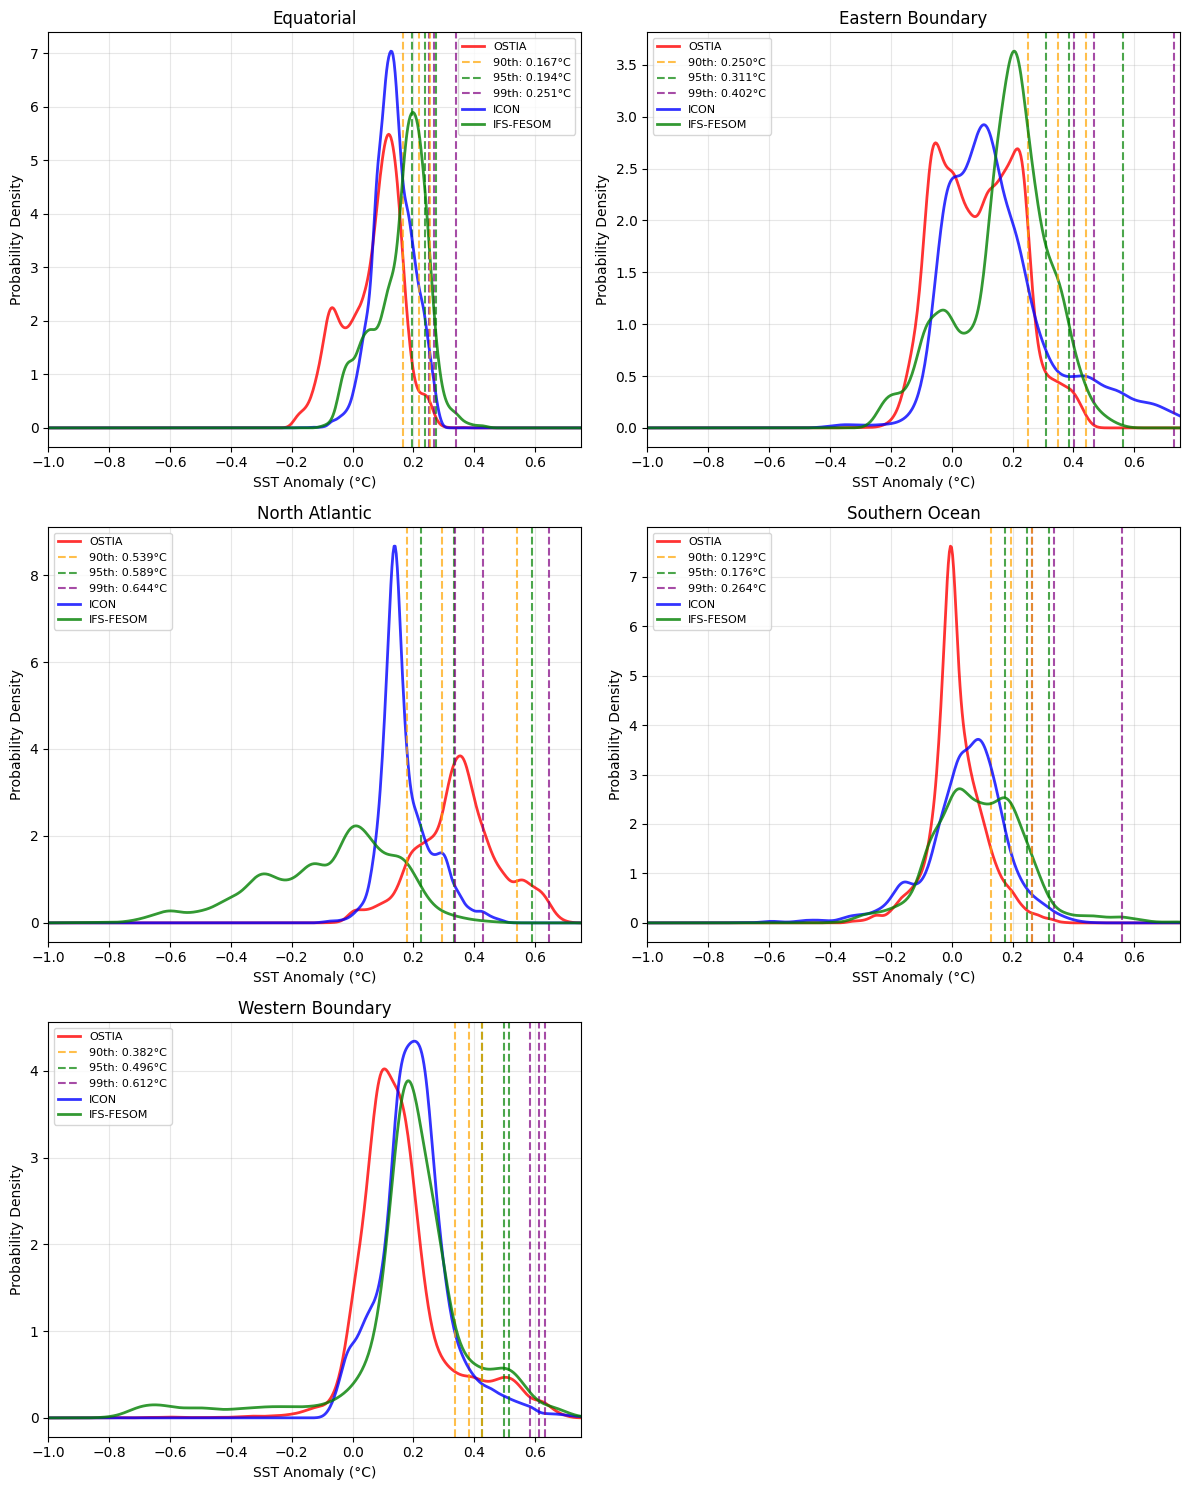

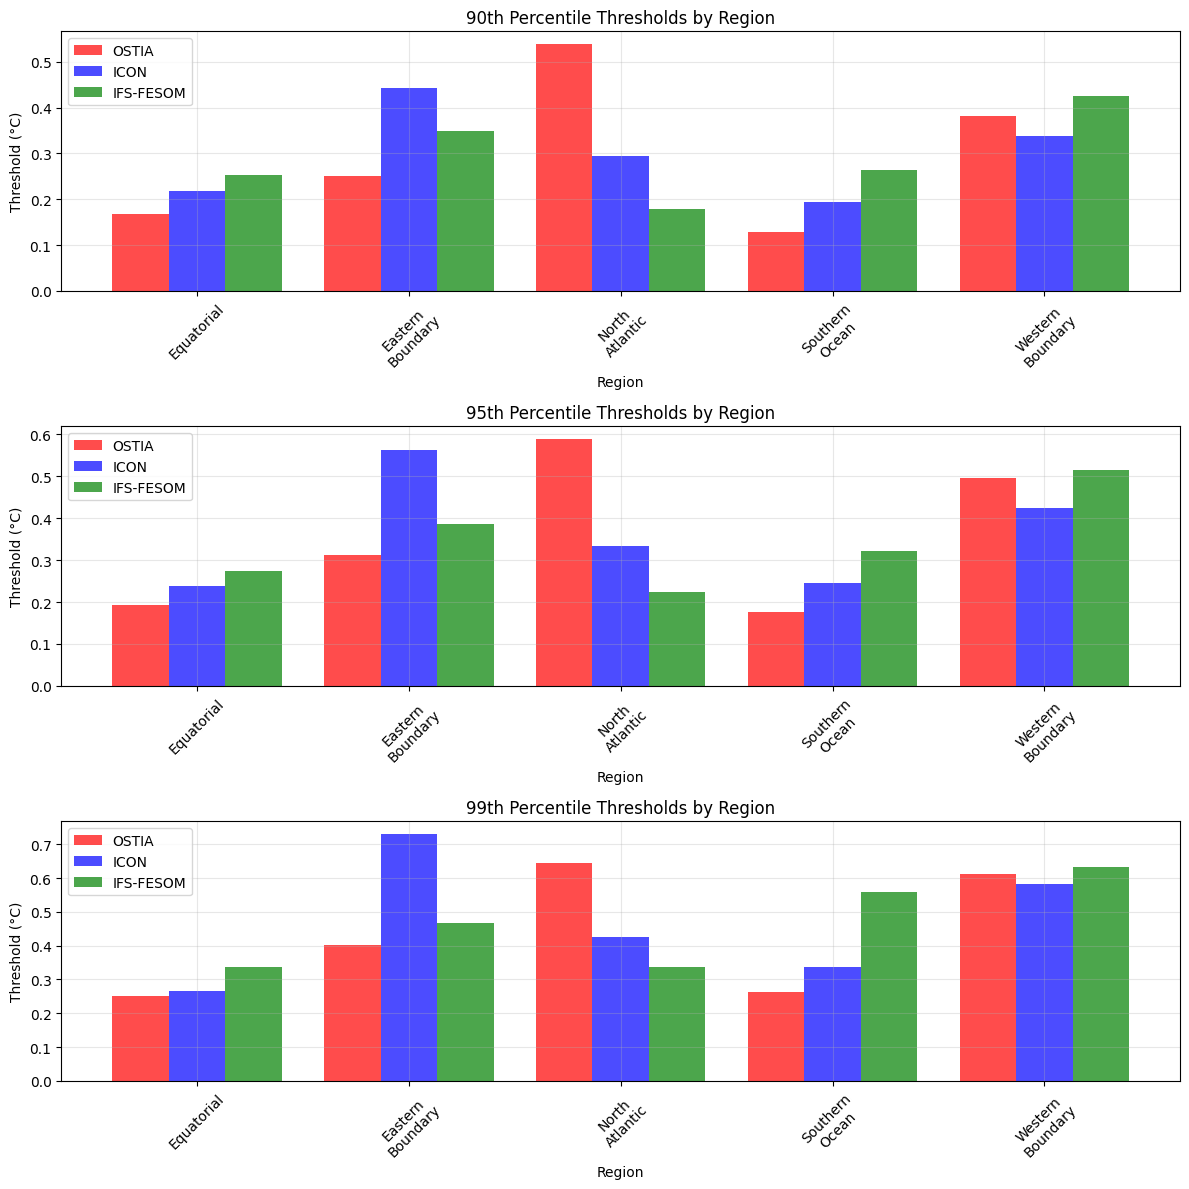


REGIONAL THRESHOLD COMPARISON:

90th Percentile Thresholds (°C):
Region               |      OSTIA |       ICON |  IFS-FESOM
-----------------------------------------------------------
Equatorial           |      0.167 |      0.218 |      0.253 | 
Eastern Boundary     |      0.250 |      0.443 |      0.348 | 
North Atlantic       |      0.539 |      0.295 |      0.179 | 
Southern Ocean       |      0.129 |      0.195 |      0.264 | 
Western Boundary     |      0.382 |      0.338 |      0.426 | 

95th Percentile Thresholds (°C):
Region               |      OSTIA |       ICON |  IFS-FESOM
-----------------------------------------------------------
Equatorial           |      0.194 |      0.239 |      0.274 | 
Eastern Boundary     |      0.311 |      0.563 |      0.387 | 
North Atlantic       |      0.589 |      0.334 |      0.224 | 
Southern Ocean       |      0.176 |      0.246 |      0.321 | 
Western Boundary     |      0.496 |      0.424 |      0.514 | 

99th Percentile Thresholds (°

In [13]:
# Example 7 multi-model comparison:

print("\n7. Multi-Model Regional Comparison")

# Create masks for all models
masks_dict = create_model_specific_masks(models_dict)

# Use the regional analysis function that handles multiple models
regional_thresholds, regional_pdfs, regional_masks = analyze_regional_extreme_thresholds(
    models_dict,
    regions=['equatorial', 'eastern_boundary', 'north_atlantic', 'southern_ocean', 'western_boundary'],
    percentiles=[90, 95, 99],  # This adds the percentile lines!
    xlim=(-1, 0.75)
)


9. Extreme Threshold Analysis
MULTI-MODEL EXTREME DETECTION THRESHOLD ANALYSIS
Using xlim: [-5, 5]
Computing percentiles for all models...
OSTIA: {90: 1.2682933807373047, 95: 1.7606323540210713, 99: 3.3208651638031057}
ICON: {90: 1.4910706043243422, 95: 2.3722426056861856, 99: 4.339255576133731}
IFS-FESOM: {90: 1.3063411712646484, 95: 1.8143216490745537, 99: 3.6741485595703125}

Computing KDE for smooth PDFs...
Computing KDE PDF for OSTIA - SST Anomaly
Total data points: 4,626,057,681
Using KDE with 1000 points
Sample size for KDE: 100,720
Computing KDE PDF for ICON - SST Anomaly
Total data points: 4,575,458,727
Using KDE with 1000 points
Sample size for KDE: 100,031
Computing KDE PDF for IFS-FESOM - SST Anomaly
Total data points: 4,558,628,542
Using KDE with 1000 points
Sample size for KDE: 100,001


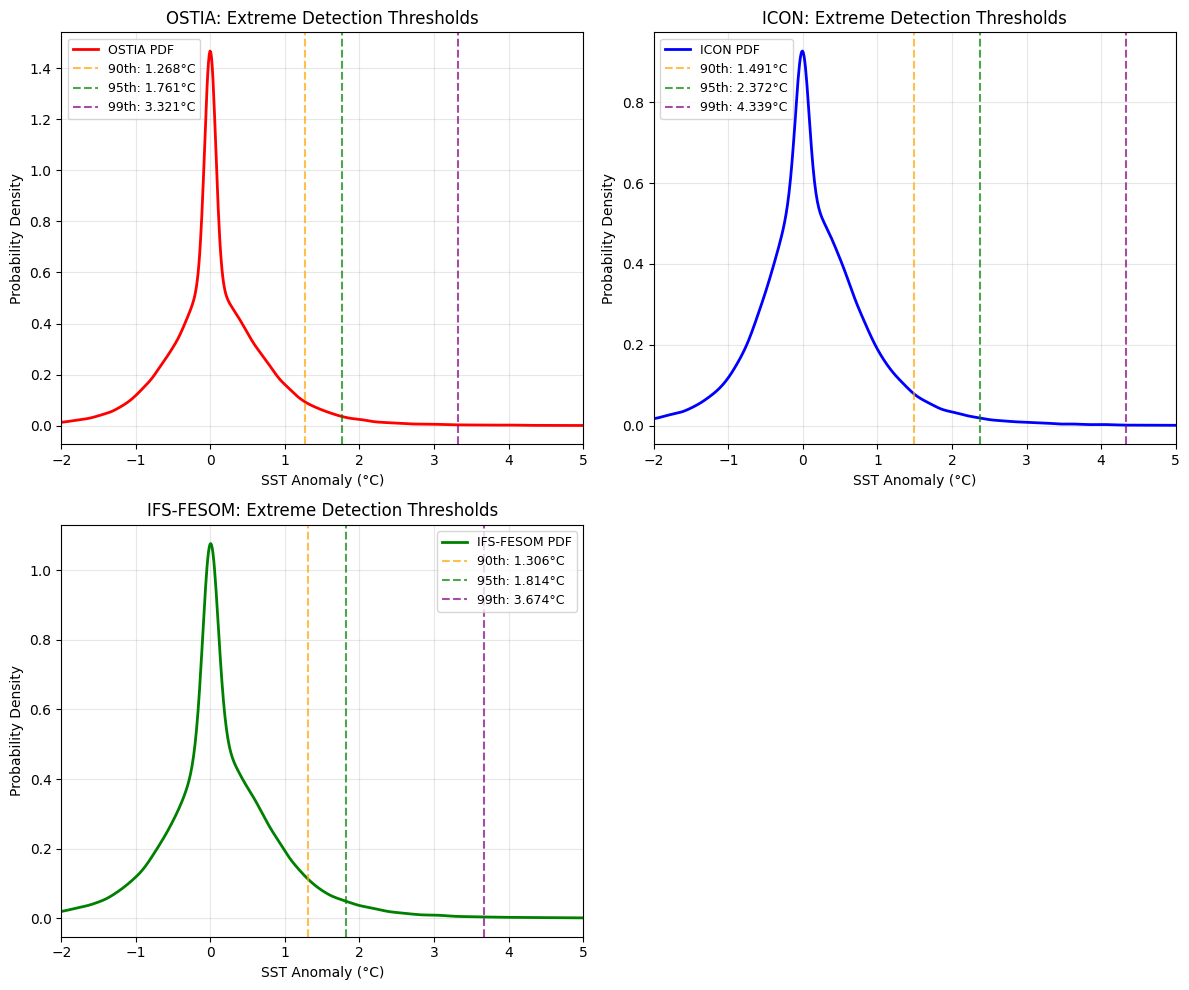

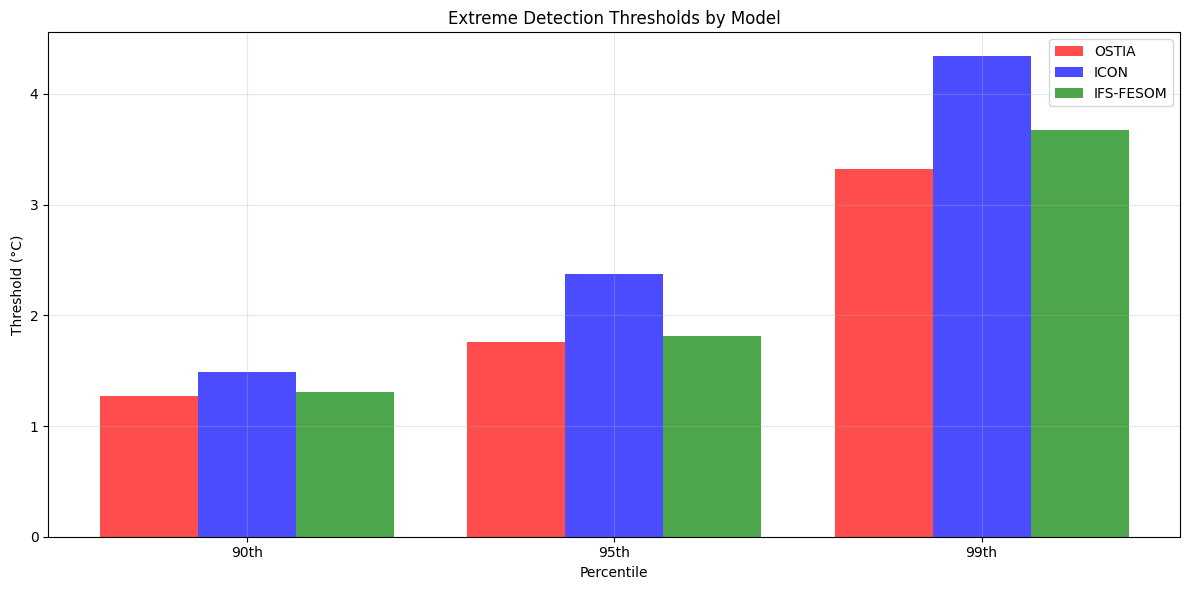


Comparative Analysis:
Percentile |    OSTIA |     ICON | IFS-FESOM
------------------------------------------------------
      90.0 |    1.268 |    1.491 |    1.306
      95.0 |    1.761 |    2.372 |    1.814
      99.0 |    3.321 |    4.339 |    3.674


In [14]:
# Example 9: Extreme threshold analysis
print("\n9. Extreme Threshold Analysis")
thresholds = analyze_multi_model_extreme_thresholds(
    models_dict, 
    percentiles=[90, 95, 99],
    xlim=(-5, 5)
)



8. Global PDF Analysis
MULTI-MODEL GLOBAL PDF COMPARISON
Computing global PDF for OSTIA - SST Anomaly
Total data points: 4,626,057,681
Using fixed range: [-5, 5]
Computing global PDF for ICON - SST Anomaly
Total data points: 4,575,458,727
Using fixed range: [-5, 5]
Computing global PDF for IFS-FESOM - SST Anomaly
Total data points: 4,558,628,542
Using fixed range: [-5, 5]


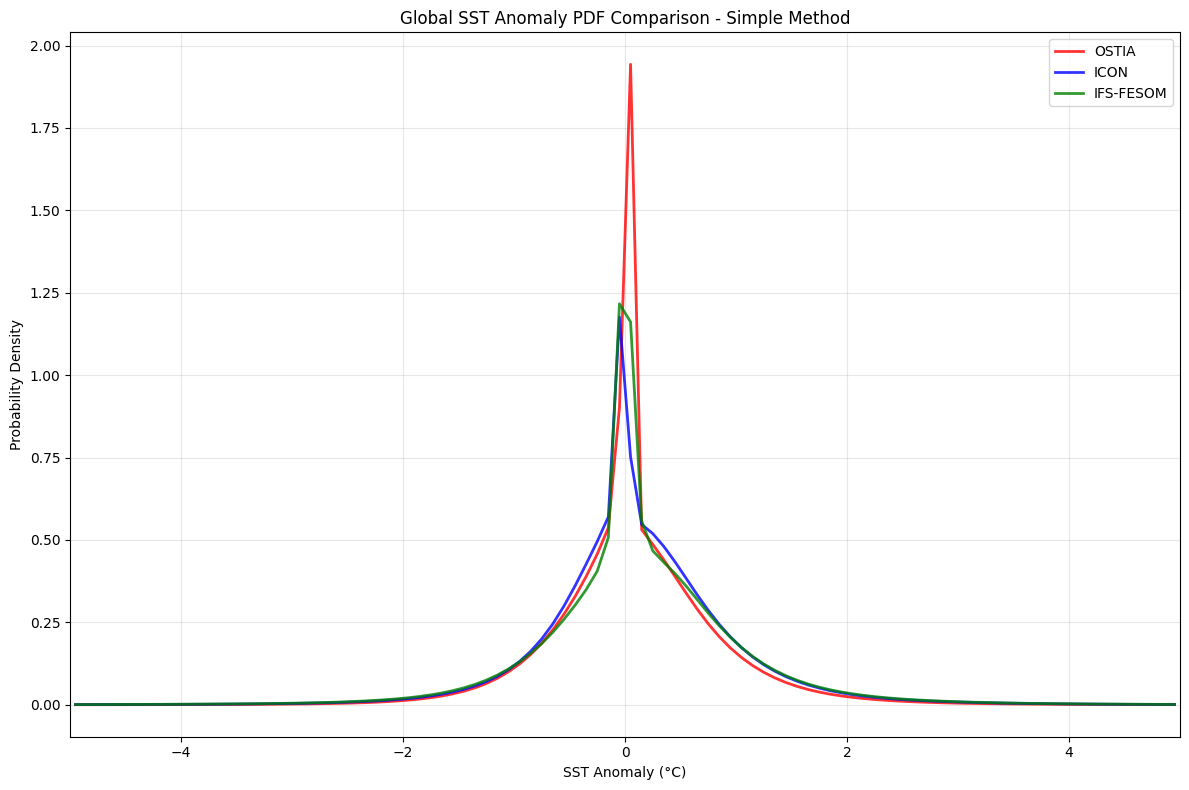


Basic Statistics:
Model           |     Mean |      Std |  Data Points
------------------------------------------------------------
OSTIA           |    0.086 |    0.733 | 4,626,057,681
ICON            |    0.120 |    0.865 | 4,575,458,727
IFS-FESOM       |    0.129 |    0.891 | 4,558,628,542
MULTI-MODEL GLOBAL PDF COMPARISON (KDE)
Using xlim: [-5, 5]
Computing KDE PDF for OSTIA - SST Anomaly
Total data points: 4,626,057,681
Using KDE with 1000 points
Sample size for KDE: 100,720
Computing KDE PDF for ICON - SST Anomaly
Total data points: 4,575,458,727
Using KDE with 1000 points
Sample size for KDE: 100,031
Computing KDE PDF for IFS-FESOM - SST Anomaly


In [ ]:
# Example 8: Global PDF analysis
print("\n8. Global PDF Analysis")
# Simple histogram method
fig, ax, simple_pdfs = plot_multi_model_pdf_comparison(
    models_dict, bins=100, title_suffix=" - Simple Method"
)

# KDE method
fig, ax, kde_pdfs = plot_multi_model_kde_comparison(
    models_dict, xlim=(-5, 5), title_suffix=" - KDE Method"
)


In [ ]:
# Example 10: Comprehensive analysis
print("\n10. Comprehensive Multi-Model Analysis")
pdfs_comp, thresholds_comp = comprehensive_multi_model_analysis(
    models_dict,
    percentiles=[90, 95, 99],
    xlim=(-5, 5)
)



11. Points Above Threshold Analysis
POINTS ABOVE THRESHOLD ANALYSIS
Computing thresholds and counting points above thresholds...
Processing OSTIA...
  90th percentile: 246,152,319 points above (5.3210%)
  95th percentile: 105,499,897 points above (2.2806%)
  99th percentile: 11,346,739 points above (0.2453%)
  99.5th percentile: 4,859,630 points above (0.1050%)
  99.9th percentile: 934,285 points above (0.0202%)
Processing ICON...
  90th percentile: 233,326,719 points above (5.0995%)
  95th percentile: 68,246,310 points above (1.4916%)
  99th percentile: 6,601,323 points above (0.1443%)
  99.5th percentile: 3,957,173 points above (0.0865%)
  99.9th percentile: 973,859 points above (0.0213%)
Processing IFS-FESOM...
  90th percentile: 331,891,089 points above (7.2805%)
  95th percentile: 157,843,491 points above (3.4625%)
  99th percentile: 17,340,052 points above (0.3804%)
  99.5th percentile: 6,268,312 points above (0.1375%)
  99.9th percentile: 851,514 points above (0.0187%)


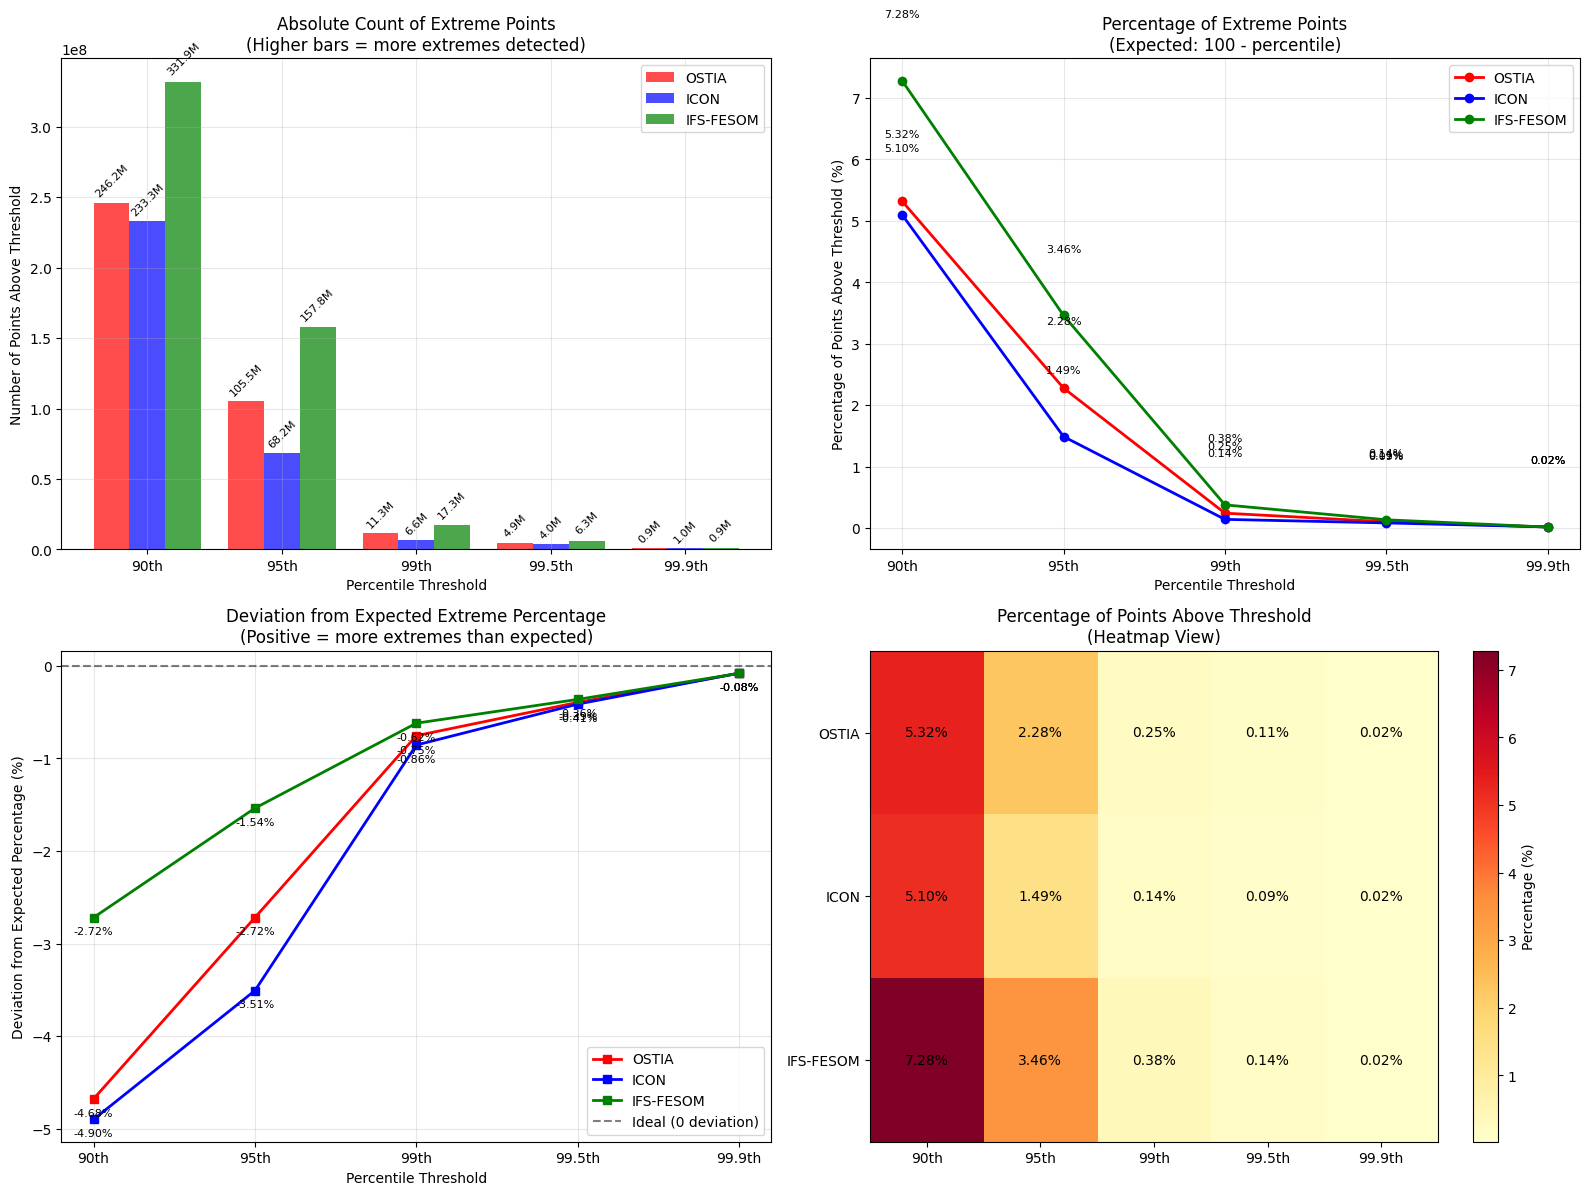


DETAILED ANALYSIS:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      1.268 |     246,152,319 |     5.321% |      10.0% |    -4.679%
             |         95 |      1.761 |     105,499,897 |     2.281% |       5.0% |    -2.719%
             |         99 |      3.321 |      11,346,739 |     0.245% |       1.0% |    -0.755%
             |       99.5 |      4.042 |       4,859,630 |     0.105% |       0.5% |    -0.395%
             |       99.9 |      5.515 |         934,285 |     0.020% |       0.1% |    -0.080%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |      

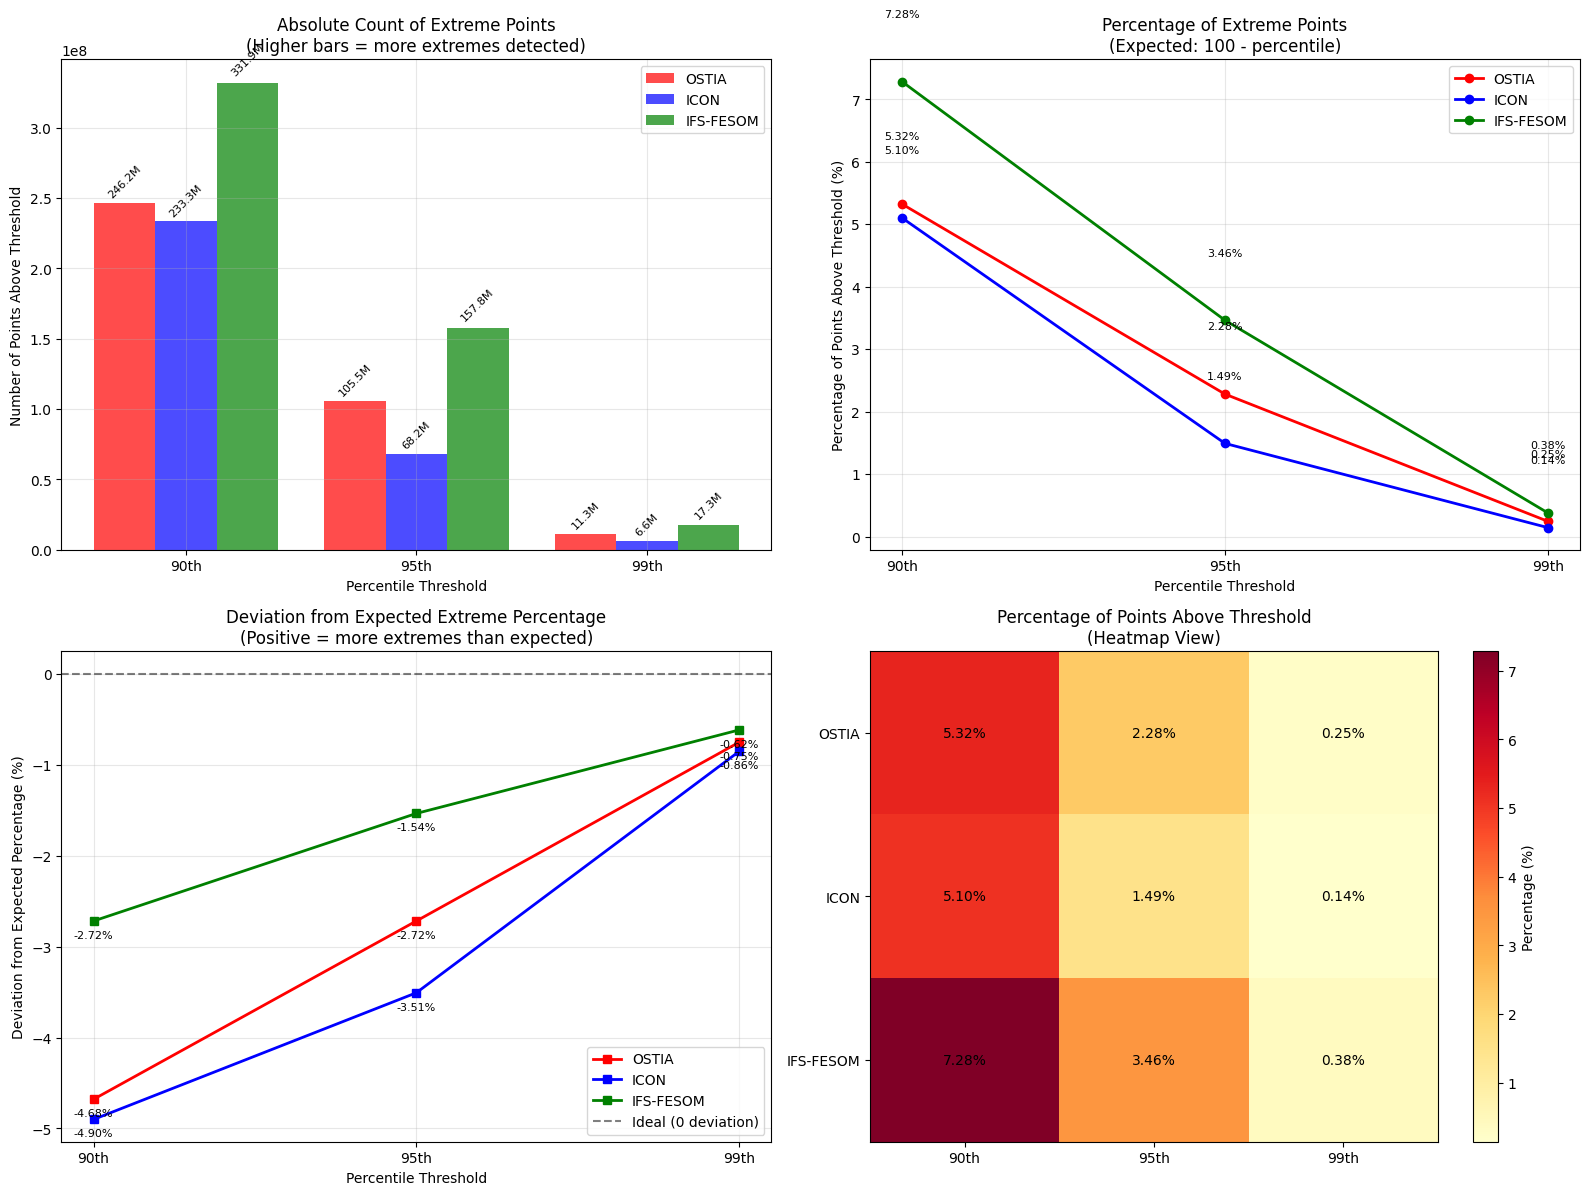


DETAILED ANALYSIS:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      1.268 |     246,152,319 |     5.321% |      10.0% |    -4.679%
             |         95 |      1.761 |     105,499,897 |     2.281% |       5.0% |    -2.719%
             |         99 |      3.321 |      11,346,739 |     0.245% |       1.0% |    -0.755%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |         90 |      1.491 |     233,326,719 |     5.100% |      10.0% |    -4.900%
             |         95 |      2.372 |      68,246,310 |     1.492% |       5.0% |    -3.508%
             |      

In [10]:
# Example 11: Points above threshold analysis
print("\n11. Points Above Threshold Analysis")
points_results = analyze_points_above_thresholds(
    models_dict,
    percentiles=[90, 95, 99, 99.5, 99.9]
)

# Quick version
quick_results = quick_points_analysis(
    models_dict,
    percentiles=[90, 95, 99]
)


In [ ]:

# Example 12: Regional means and anomalies
print("\n12. Regional Means and Anomalies")
# Create mask DataArray
mask_da_stacked = create_mask_dataarray(lats, lons, masks)

# Compute region means for OSTIA
ostia_da = models_dict['OSTIA'][0]['dat_anomaly']
region_means_ostia = compute_region_means_anomalies(ostia_da, mask_da_stacked)

# Compute for all models
region_means_dict = {}
for model_name, (model_ds, var_name) in models_dict.items():
    model_lats = model_ds.lat.values
    model_lons = model_ds.lon.values
    model_masks = create_oceanic_regions_mask(model_lats, model_lons)
    model_mask_da = create_mask_dataarray(model_lats, model_lons, model_masks)
    region_means_dict[model_name] = compute_region_means_anomalies(model_ds[var_name], model_mask_da)

# Compute statistics
temporal_means, temporal_stds = compute_anomaly_statistics(
    region_means_dict, list(models_dict.keys())
)

# Plot comparisons
plot_region_anomaly_comparison(
    temporal_means, temporal_stds, 
    list(masks.keys()), list(models_dict.keys()),
    plot_type='means', title_suffix='- All Models'
)


In [ ]:

# Example 13: Memory-efficient chunked processing
print("\n13. Memory-Efficient Processing")
# For large datasets, use chunked processing
region_means_chunked = compute_region_means_chunked(
    ostia_da, mask_da_stacked, time_chunk_size=100
)


In [ ]:
# Example 14: Diagnostic functions
print("\n14. Diagnostic Functions")
diagnose_region_means(region_means_dict, list(models_dict.keys()))

# Compare data structures
if 'ICON' in region_means_dict:
    compare_data_structures(
        region_means_ostia, region_means_dict['ICON'],
        name1="OSTIA", name2="ICON"
    )


In [ ]:

# Example 15: Regional analysis
print("\n15. Regional Analysis")
# Create model-specific masks
masks_dict = create_model_specific_masks(models_dict)

# Memory-efficient regional PDF comparison
regional_pdfs = plot_regional_pdf_comparison_memory_efficient(
    models_dict, masks_dict, 
    regions=['equatorial', 'north_atlantic', 'southern_ocean'],
    xlim=(-3, 3)
)

# Regional extreme thresholds
regional_extremes = analyze_regional_extreme_thresholds_memory_efficient(
    models_dict, masks_dict,
    regions=['equatorial', 'north_atlantic'],
    percentiles=[90, 95, 99]
)

# Comprehensive regional analysis
regional_thresholds, regional_pdfs_comp, regional_masks = analyze_regional_extreme_thresholds(
    models_dict,
    regions=['western_boundary', 'eastern_boundary', 'equatorial'],
    percentiles=[90, 95, 99],
    xlim=(-3, 3)
)

# Quick regional analysis (all-in-one)
print("\n16. Quick Regional Analysis")
quick_pdfs, quick_extremes, quick_masks = quick_regional_analysis(
    models_dict,
    regions=['equatorial', 'north_atlantic'],
    xlim=(-3, 3)
)

In [ ]:

# Example 17: Save results
print("\n17. Saving Results")
# Save region means
save_region_means_direct(region_means_ostia, 'ostia_region_means.nc')

print("\n=== ALL EXAMPLES COMPLETED ===")

# Print summary of key results
print("\n=== KEY RESULTS SUMMARY ===")
print("Global Extreme Thresholds (95th percentile):")
for model, thresh in thresholds.items():
    print(f"  {model}: {thresh[95]:.3f}°C")

print("\nRegional Comparison (Equatorial region means):")
for model, means in temporal_means.items():
    equatorial_idx = list(masks.keys()).index('equatorial')
    print(f"  {model}: {means[equatorial_idx]:.3f}°C")

# GLOBAL PDFs

In [8]:

# Create models dictionary
models_dict = {
    'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),  # Uncomment when you have this data
    # 'Other_Model': (other_ds, 'dat_anomaly'),    # Add more models here
}


In [12]:
# Run with your desired xlim
fig, ax, pdfs = plot_multi_model_kde_comparison(models_dict, xlim=(-5, 5))

NameError: name 'plot_multi_model_kde_comparison' is not defined

MULTI-MODEL EXTREME DETECTION THRESHOLD ANALYSIS
Using xlim: [-5, 5]
OSTIA: {90: 1.2682933807373047, 95: 1.7606323540210713, 99: 3.3208651638031057, 99.5: 4.041970150470718, 99.9: 5.51452805042274}
ICON: {90: 1.4910706043243422, 95: 2.3722426056861856, 99: 4.339255576133731, 99.5: 4.793771626949308, 99.9: 6.221519947065365}
IFS-FESOM: {90: 1.3063411712646484, 95: 1.8143216490745537, 99: 3.6741485595703125, 99.5: 4.644503369331346, 99.9: 6.643003230115065}

Computing KDE for smooth PDFs...
Computing KDE PDF for OSTIA - SST Anomaly
Total data points: 4,626,057,681
Using KDE with 1000 points
Sample size for KDE: 100,720
Computing KDE PDF for ICON - SST Anomaly
Total data points: 4,575,458,727
Using KDE with 1000 points
Sample size for KDE: 100,031
Computing KDE PDF for IFS-FESOM - SST Anomaly
Total data points: 4,558,628,542
Using KDE with 1000 points
Sample size for KDE: 100,001


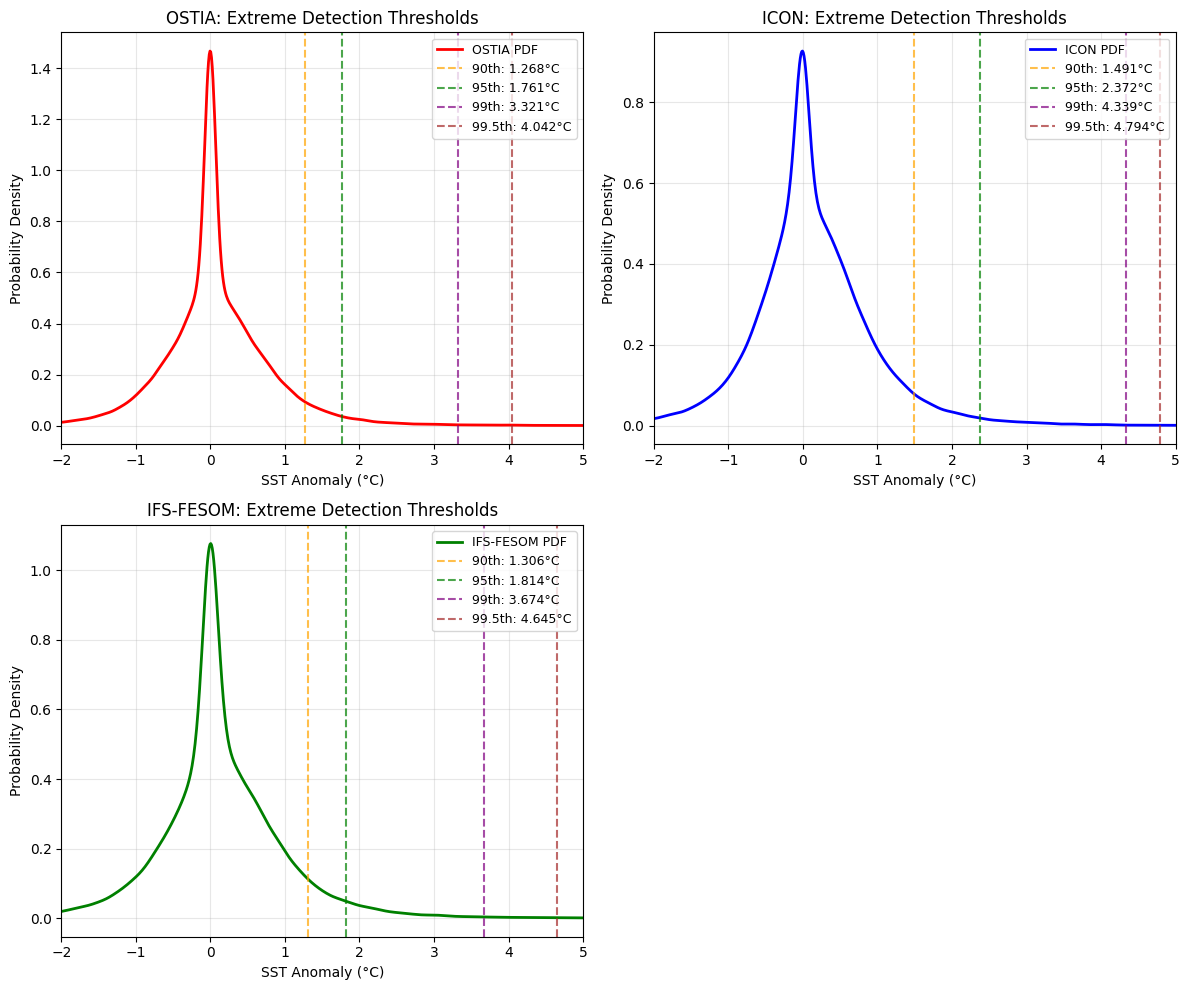

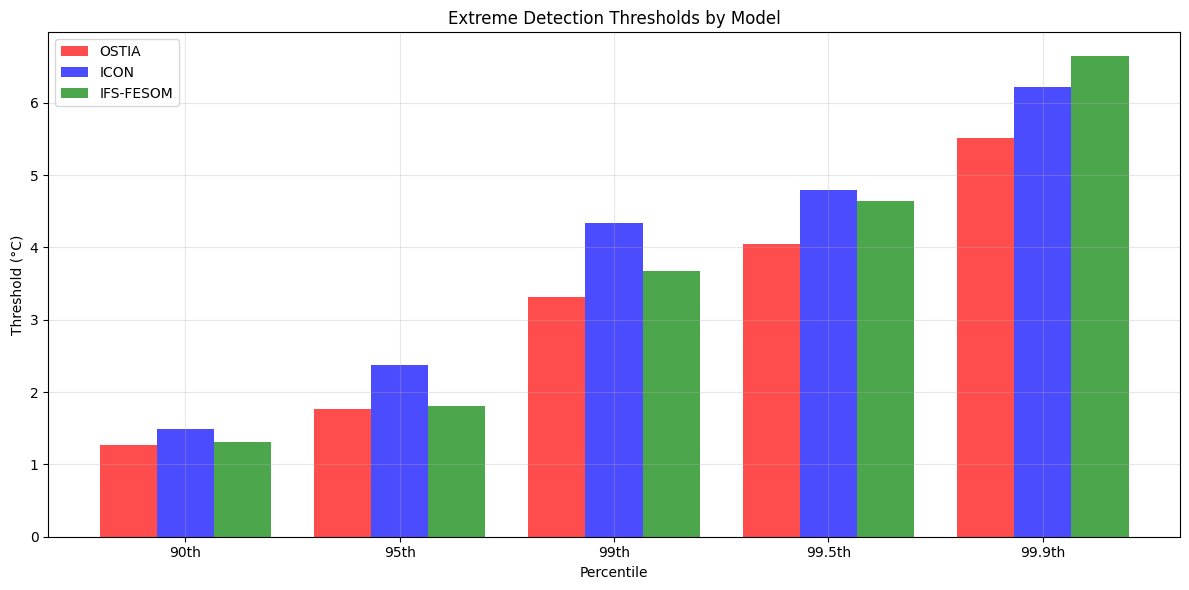


Comparative Analysis:
Percentile |    OSTIA |     ICON | IFS-FESOM
------------------------------------------------------
      90.0 |    1.268 |    1.491 |    1.306
      95.0 |    1.761 |    2.372 |    1.814
      99.0 |    3.321 |    4.339 |    3.674
      99.5 |    4.042 |    4.794 |    4.645
      99.9 |    5.515 |    6.222 |    6.643


In [10]:
thresholds = analyze_multi_model_extreme_thresholds(models_dict, xlim=(-5, 5))

POINTS ABOVE THRESHOLD ANALYSIS
Computing thresholds and counting points above thresholds...
Processing OSTIA...
  90th percentile: 246,152,319 points above (5.3210%)
  95th percentile: 105,499,897 points above (2.2806%)
  99th percentile: 11,346,739 points above (0.2453%)
  99.5th percentile: 4,859,630 points above (0.1050%)
  99.9th percentile: 934,285 points above (0.0202%)
Processing ICON...
  90th percentile: 233,326,719 points above (5.0995%)
  95th percentile: 68,246,310 points above (1.4916%)
  99th percentile: 6,601,323 points above (0.1443%)
  99.5th percentile: 3,957,173 points above (0.0865%)
  99.9th percentile: 973,859 points above (0.0213%)
Processing IFS-FESOM...
  90th percentile: 331,891,089 points above (7.2805%)
  95th percentile: 157,843,491 points above (3.4625%)
  99th percentile: 17,340,052 points above (0.3804%)
  99.5th percentile: 6,268,312 points above (0.1375%)
  99.9th percentile: 851,514 points above (0.0187%)


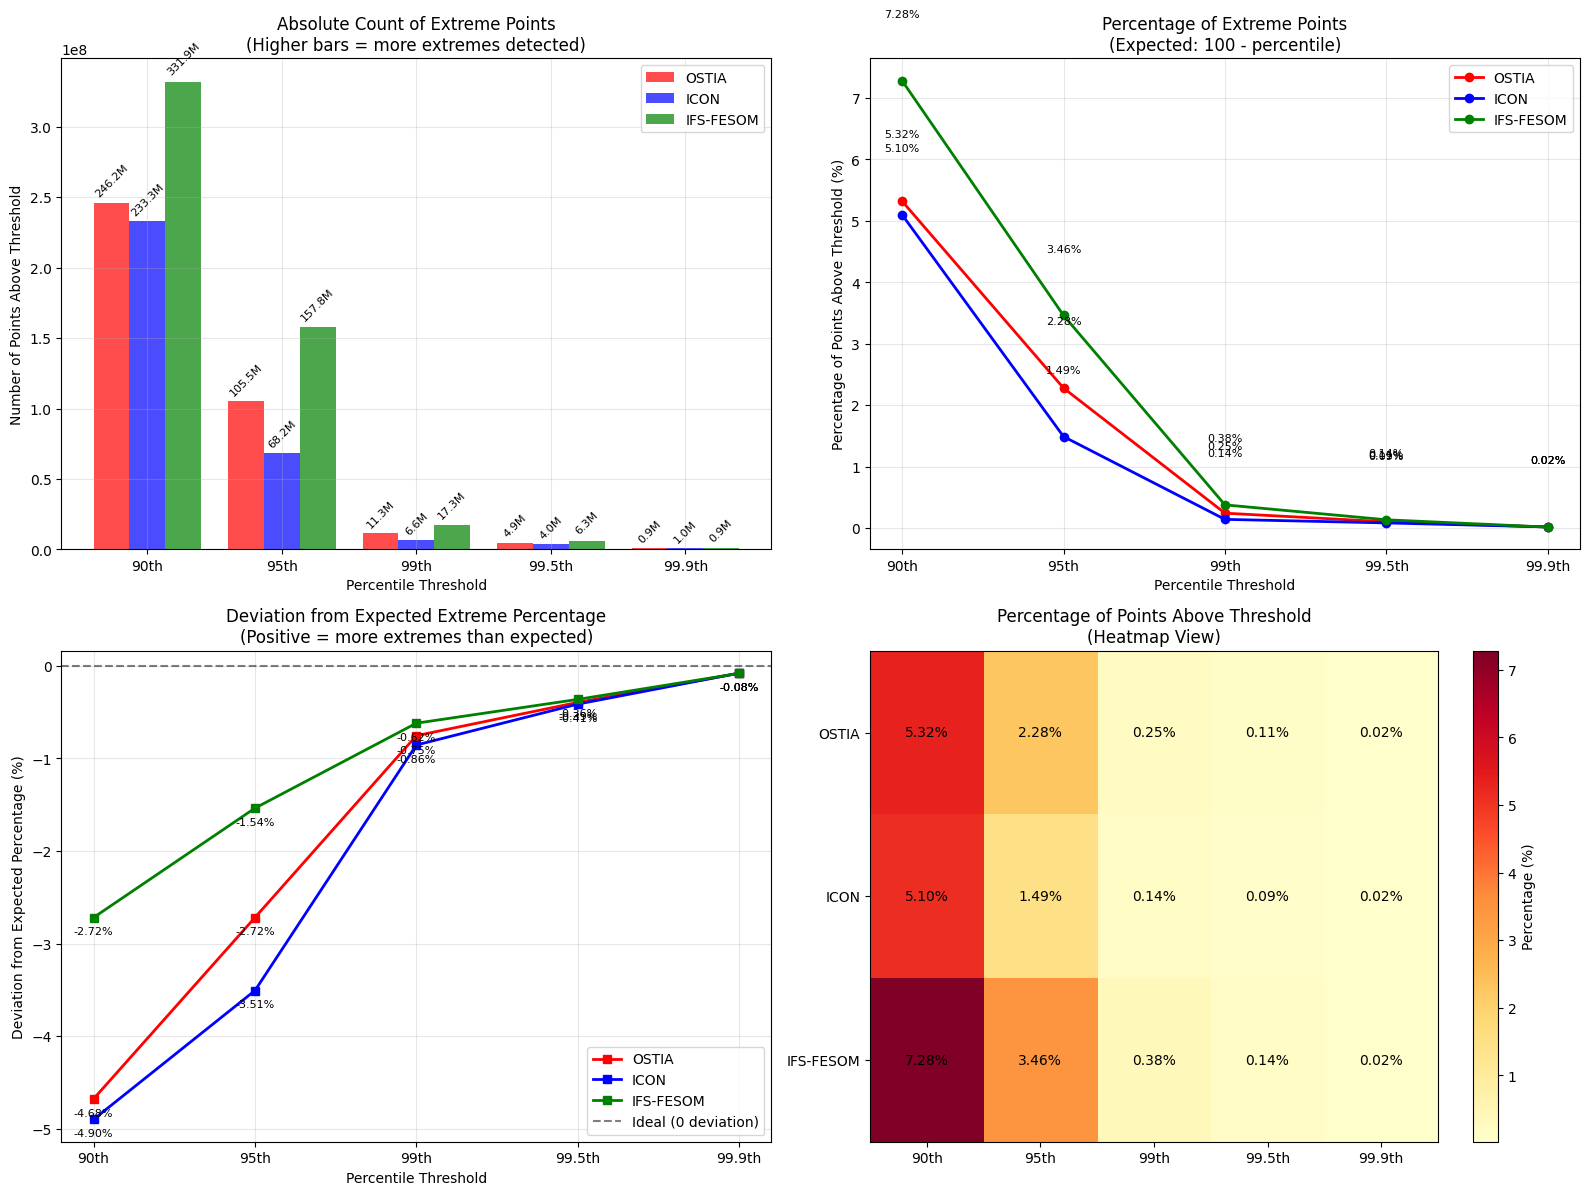


DETAILED ANALYSIS:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      1.268 |     246,152,319 |     5.321% |      10.0% |    -4.679%
             |         95 |      1.761 |     105,499,897 |     2.281% |       5.0% |    -2.719%
             |         99 |      3.321 |      11,346,739 |     0.245% |       1.0% |    -0.755%
             |       99.5 |      4.042 |       4,859,630 |     0.105% |       0.5% |    -0.395%
             |       99.9 |      5.515 |         934,285 |     0.020% |       0.1% |    -0.080%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |      

In [12]:
# Full detailed analysis
results = analyze_points_above_thresholds(models_dict)


QUICK POINTS ABOVE THRESHOLD ANALYSIS
POINTS ABOVE THRESHOLD ANALYSIS
Computing thresholds and counting points above thresholds...
Processing OSTIA...
  90th percentile: 246,152,319 points above (5.3210%)
  95th percentile: 105,499,897 points above (2.2806%)
  99th percentile: 11,346,739 points above (0.2453%)
  99.5th percentile: 4,859,630 points above (0.1050%)
  99.9th percentile: 934,285 points above (0.0202%)
Processing ICON...
  90th percentile: 233,326,719 points above (5.0995%)
  95th percentile: 68,246,310 points above (1.4916%)
  99th percentile: 6,601,323 points above (0.1443%)
  99.5th percentile: 3,957,173 points above (0.0865%)
  99.9th percentile: 973,859 points above (0.0213%)


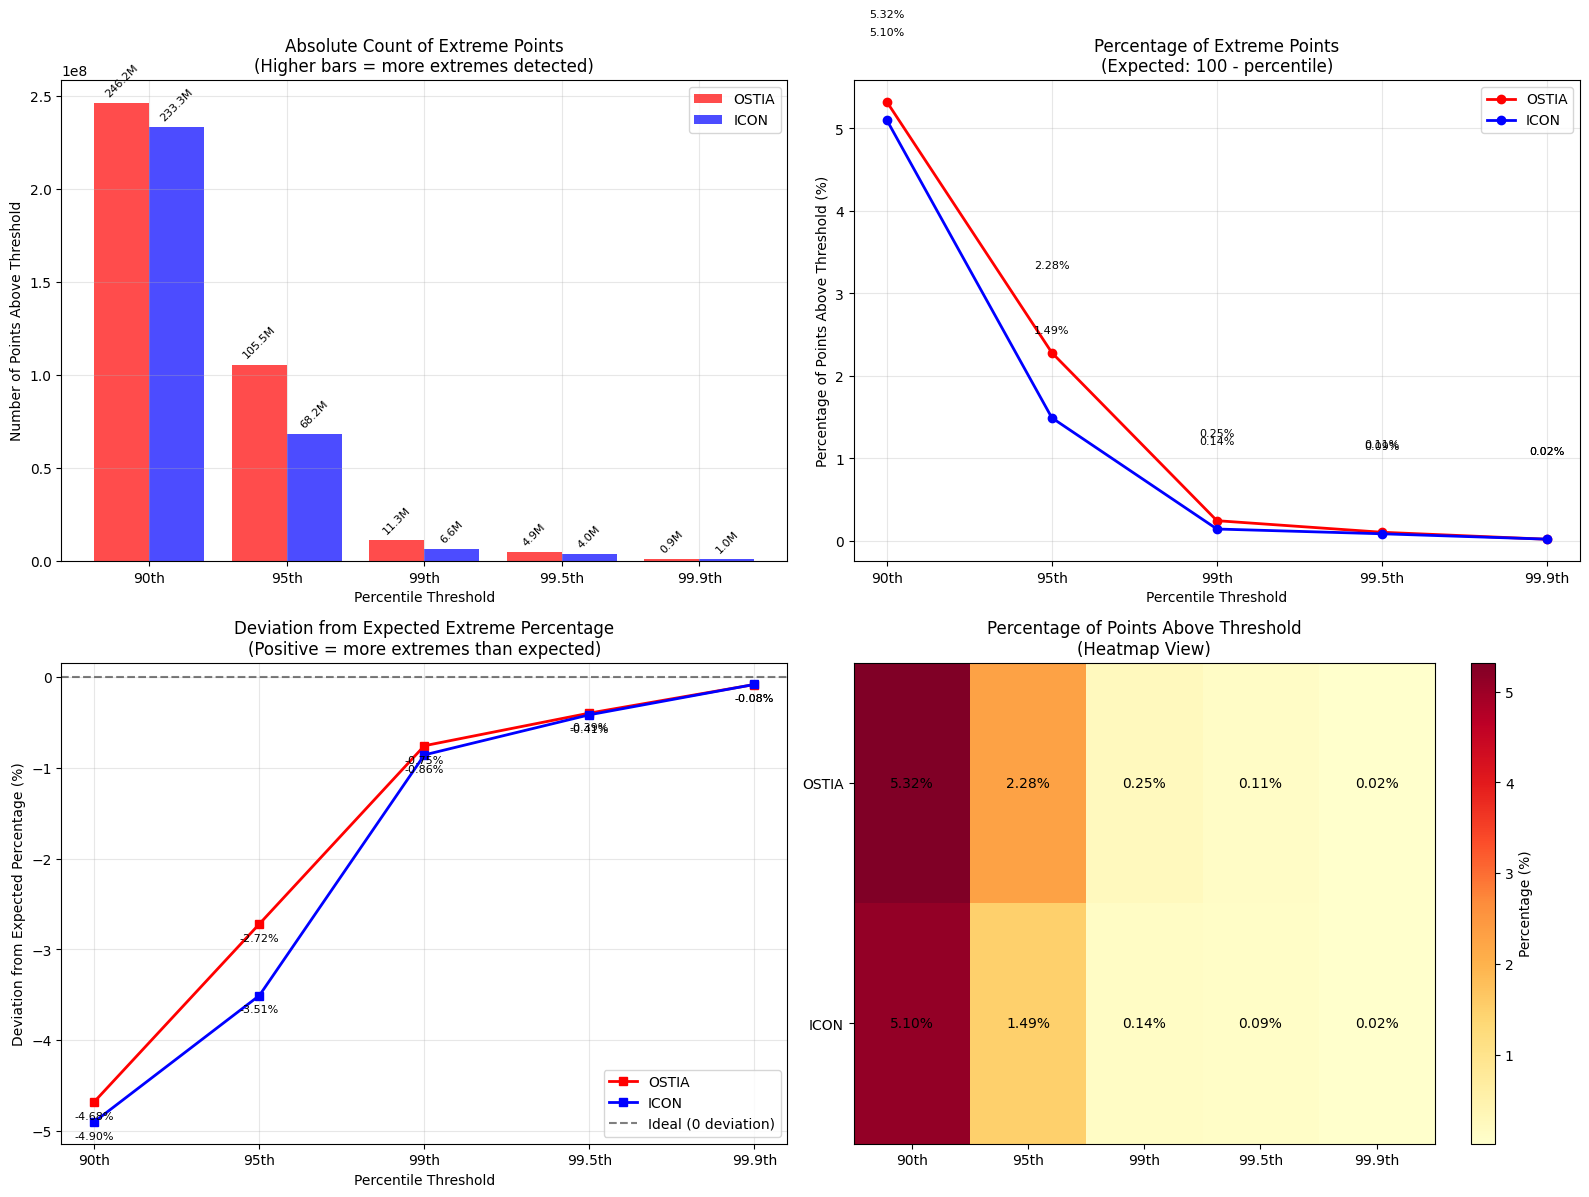


DETAILED ANALYSIS:
Model        | Percentile |  Threshold |    Points Above |    % Above | Expected % |  Deviation
-----------------------------------------------------------------------------------------------
OSTIA        |            |            |                 |            |            |           
             |         90 |      1.268 |     246,152,319 |     5.321% |      10.0% |    -4.679%
             |         95 |      1.761 |     105,499,897 |     2.281% |       5.0% |    -2.719%
             |         99 |      3.321 |      11,346,739 |     0.245% |       1.0% |    -0.755%
             |       99.5 |      4.042 |       4,859,630 |     0.105% |       0.5% |    -0.395%
             |       99.9 |      5.515 |         934,285 |     0.020% |       0.1% |    -0.080%
-----------------------------------------------------------------------------------------------
ICON         |            |            |                 |            |            |           
             |      

In [8]:

# Quick summary only  
quick_results = quick_points_analysis(models_dict)


In [ ]:

# You can also use different percentiles
#custom_percentiles = [80, 85, 90, 95, 99]
custom_results = analyze_points_above_thresholds(models_dict, percentiles=custom_percentiles)